In [2]:
import os
import glob
import pandas as pd
import numpy as np
from collections import Counter,defaultdict
import re
import pickle
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import csv

pd.options.display.max_rows = 999

/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
df = pd.read_pickle('../1_data_scraping/dedup_combined_df.pkl')
df.shape#df.head(10)

(44582, 10)

In [5]:
TOPICS = ['cc','vax','covid']
SIDES = ['pro','anti']

In [6]:
BLACKLIST_SUBJS = set(['that','one','this','percent','’s','some','many','those','other','“','who',
                      '—','which'])

In [7]:
good_quotes = pickle.load(open('../2_data_processing/good_coref_quotes.pkl','rb'))
covid_quotes = pickle.load(open('../2_data_processing/filtered_covid_quotes.pkl','rb'))
len(good_quotes),len(covid_quotes)

(434634, 223227)

In [8]:
all_quotes = good_quotes+covid_quotes
len(all_quotes)

657861

In [9]:
cc_quotes = [q for q in good_quotes if q['topic'] == 'cc']
vax_quotes = [q for q in good_quotes if q['topic'] == 'vax']
quotes_by_topic_side = {'cc':{'pro':[q for q in cc_quotes if q['stance']=='pro'],
                         'anti':[q for q in cc_quotes if q['stance']=='anti']},
                   'vax':{'pro':[q for q in vax_quotes if q['stance']=='pro'],
                         'anti':[q for q in vax_quotes if q['stance']=='anti']},
                   'covid':{'pro':[q for q in covid_quotes if q['stance']=='pro'],
                         'anti':[q for q in covid_quotes if q['stance']=='anti']}}

In [10]:
for topic in quotes_by_topic_side:
    for side in quotes_by_topic_side[topic]:
        print(topic,side,len(quotes_by_topic_side[topic][side]))

cc pro 277925
cc anti 117404
vax pro 25753
vax anti 8421
covid pro 126826
covid anti 95796


In [177]:
# quotes_per_year = defaultdict(list)
# for q in good_quotes:
#     y = df.loc[df.url == q['source']].year.values[0]
#     quotes_per_year[y].append(q)

In [179]:
#pickle.dump(quotes_per_year,open('quotes_per_year.pkl','wb'))

In [186]:
for year in quotes_per_year:
    if not np.isnan(year):
        print(year,len(quotes_per_year[year]))

2019.0 72916
2013.0 22811
2017.0 46641
2018.0 52289
2015.0 38027
2010.0 14066
2020.0 46177
2011.0 13405
2012.0 17074
2014.0 33307
2009.0 9629
2016.0 38855
2006.0 1976
2007.0 5854
2003.0 533
2005.0 681
2008.0 10054
1995.0 123
1972.0 21
1993.0 164
2000.0 265
2004.0 654
2001.0 505
1997.0 189
1986.0 15
1996.0 72
1977.0 9
1998.0 125
1992.0 40
1989.0 257
1990.0 202
2002.0 290
1991.0 160
1973.0 9
1985.0 1
1999.0 104
1983.0 49
1987.0 5
1988.0 29
1976.0 6
1979.0 31
1984.0 21
1994.0 19
1981.0 16
1982.0 6


In [11]:
#good_quotes[0]

In [11]:
ent_fuzzy_map = pickle.load(open('named_entity_fuzzymatch_map.pkl','rb'))

### Clean superfluous whitespace

In [163]:
import re
re.sub("\s\s+",'','"   e&e')

'"e&e'

In [166]:
whitespace_cleaned_quotes = []
for q in good_quotes:
    for key in ['main verb lemma','main verb lemma coref','main subject lemma','main subject lemma coref']:
        if q[key] is not None:
            q[key] = re.sub("\s\s+",'',q[key])
    whitespace_cleaned_quotes.append(q)

In [167]:
pickle.dump(whitespace_cleaned_quotes,open('../data_processing/good_coref_quotes.pkl','wb'))

### Add outlet stance, topic fields to each quote

In [374]:
updated_quotes = []

In [375]:
for q in covid_quotes:
    if 'stance' not in q.keys():
        stance = get_src_attr(q['source'],'stance')
        topic = get_src_attr(q['source'],'topic')
        q.update({'stance':stance,'topic':topic})
    updated_quotes.append(q)

KeyboardInterrupt: 

In [361]:
len(covid_quotes),len(updated_quotes)

(434634, 434634)

In [371]:
len(covid_quotes),len(cc_quotes),len(vax_quotes)

(0, 400460, 34174)

In [58]:
pickle.dump(updated_quotes,open('../data_processing/good_coref_quotes.pkl','wb'))

### Fuzzy matching to collapse subj entities

In [14]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [19]:
NEs = pd.read_csv('annotated_NE_df.pkl')
NEs = NEs.drop(['Unnamed: 0','Unnamed: 1'],axis=1)
NEs.head()

Unnamed: 0.1              NE ent_type  is_sci ent_domain stance  is_media  \
0           0.0    Donald Trump      pol   False        NaN    rep     False   
1           1.0    Barack Obama      pol   False        NaN    dem     False   
2           2.0        Facebook     tech   False        NaN    NaN     False   
3           3.0  Bernie Sanders      pol   False        NaN    dem     False   
4           4.0      Xi Jinping      pol   False        NaN    NaN     False   

   is_tech  is_activist  is_pol  is_cc  is_covid  is_vax  
0    False        False    True  False     False   False  
1    False        False    True  False     False   False  
2     True        False   False  False     False   False  
3    False        False    True  False     False   False  
4    False        False    True  False     False   False

In [196]:
NEs.shape

(911, 12)

In [197]:
name_groups = NEs.groupby('NE')
dup_NEs = [x for x in name_groups.first().index if len(name_groups.get_group(x)) > 1]
dup_NEs

[]

In [16]:
NE_stance_dict = pickle.load(open('../4_analyses/NE_stance_dict.pkl','rb'))

In [17]:
NE_stance_dict['World Health Organization']

{'vax': 'pro', 'covid': 'pro'}

In [ ]:
'democrats','republicans',
'liberals','conservatives',

In [181]:
#ent_fuzzy_dict = defaultdict(list)

In [21]:
new_econs = ['peter navarro','richard tol','mark perry','nicholas stern','laurence boone','keith collins',
'william stanley jevons','william nordhaus','chris costello','stephen moore','robert murphy','david kreutzer',
'Gary Cohn','robert stavins','robert pindyck','robert gordon','peter dorman','aloulou fawzi','lucas chancel',
'thomas piketty','samuel h. williamson','louis p. cain','peter sheehan','john m. reilly','robert w. godby',
'roger h. bezdek','paul romer','marshall burke','gordon hughes','rachel cleetus','eli berman','ross garnaut',
'clive hamilton','marc hafstead','frederick chen','john newton','john felmy','robert h. frank',
'andy critchlow']

In [211]:
# Make sure main_subjs_dict is up to date!

for ent in new_econs:#NEs.NE.values:
    print(ent)
    if ent in NE_stance_dict:
        for topic in NE_stance_dict[ent]:
            pro_subjs = set(main_subjs_dict[topic]['pro'])
            anti_subjs = set(main_subjs_dict[topic]['anti'])
            fuzzy_matches = [x[0] for x in process.extract(ent, pro_subjs|anti_subjs, limit=100) 
             if x[1] >= 85 and len(x[0])>=len(ent)][:30]
            ent_fuzzy_dict[ent] = fuzzy_matches
    else:
        pro_subjs = set(main_subjs_dict['cc']['pro'])|set(main_subjs_dict['covid']['pro'])
        anti_subjs = set(main_subjs_dict['cc']['anti'])|set(main_subjs_dict['covid']['anti'])
        fuzzy_matches = [x[0] for x in process.extract(ent, pro_subjs|anti_subjs, limit=100) 
             if x[1] >= 85 and len(x[0])>=len(ent)][:30]
        ent_fuzzy_dict[ent] = fuzzy_matches

peter navarro
richard tol
mark perry
nicholas stern
laurence boone
keith collins
william stanley jevons
william nordhaus
chris costello
stephen moore
robert murphy
david kreutzer
Gary Cohn
robert stavins
robert pindyck
robert gordon
peter dorman
aloulou fawzi
lucas chancel
thomas piketty
samuel h. williamson
louis p. cain
peter sheehan
john m. reilly
robert w. godby
roger h. bezdek
paul romer
marshall burke
gordon hughes
rachel cleetus
eli berman
ross garnaut
clive hamilton
marc hafstead
frederick chen
john newton
john felmy
robert h. frank
andy critchlow


In [203]:
# ent_fuzzy_dict['National Oceanic and Atmospheric Administration'].extend(['NOAA','N.O.A.A.'])
# ent_fuzzy_dict['Center for Disease Control and Prevention'].extend(['CDC','C.D.C.'])
# ent_fuzzy_dict['Federal Drug Administration'].extend(['FDA','F.D.A.'])
# ent_fuzzy_dict['National Institute of Health'].extend(['NIH','N.I.H.'])
# ent_fuzzy_dict['NASA'].extend(['N.A.S.A.','National Aeronautics and Space Administration'])

In [212]:
with open('NE_fuzzy_matches.csv','w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    for ent in ent_fuzzy_dict:
        writer.writerow([ent]+list(ent_fuzzy_dict[ent]))

In [227]:
ent_fuzzy_dict['E.P.A.']

[]

In [318]:
# Manually add 
ent_fuzzy_dict['Alexandria Ocasio-Cortez'].extend(['aoc','alexandria ocasio-cortez'])
# ent_fuzzy_dict['United Nations'].extend(['the u.n.', 'the un', 'u.n.', 'un'])
# ent_fuzzy_dict['Scott Pruit'].append('mr. pruitt')
# ent_fuzzy_dict['Donald Trump'].extend(['Mr. Trump','President Trump'])
# ent_fuzzy_dict['Bernie Sanders'].extend(['Mr. Sanders'])
# ent_fuzzy_dict['Al Gore'].append('Mr. gore')
# ent_fuzzy_dict['Barack Obama'].append('Mr. Obama')
# ent_fuzzy_dict['Bill Clinton'].append('Mr. clinton')
# ent_fuzzy_dict['Joe Biden'].append('Mr. Biden')
# ent_fuzzy_dict['Pete Buttigieg'].append('Mr. Buttigieg')
# ent_fuzzy_dict['Michael Bloomberg'].extend(['mike bloomberg','mr. bloomberg'])

In [321]:
#del ent_fuzzy_dict['e.p.a.']
ent_fuzzy_dict['e.p.a.'] = ['environmental protection agency','the e.p.a.','epa','the epa']

In [322]:
ent_fuzzy_map = {}
for ent in NEs.NE.values:
    ent_fuzzy_map.update(dict(zip(ent_fuzzy_dict[ent],[ent]*len(ent_fuzzy_dict[ent]))))

In [323]:
pickle.dump(ent_fuzzy_map,open('named_entity_fuzzymatch_map.pkl','wb'))

In [189]:
# Update main_subjs_dict with collapsed NEs
main_subjs_dict = defaultdict(dict)
for topic in TOPICS:
    for side in SIDES:
        main_subj_qs = [q for q in all_quotes 
                                        if q['main subject lemma coref'] is not None 
                                        and q['stance'] == side and 
                                        q['topic'] == topic]
        main_subjs_ = [x['main subject lemma coref'].lower() if x['main subject lemma coref'] != '-PRON-'
                      else x['main subject text'].lower() for x in main_subj_qs]
        #main_subjs_ = [ent_fuzzy_map[x] if x in ent_fuzzy_map else x for x in main_subjs_]
        main_subjs_dict[topic][side] = main_subjs_

In [190]:
len(main_subjs_dict['covid']['pro'])

115505

### Collapse 'hop' and 'hope'

In [141]:
hop_quotes = [q for q in good_quotes if q['main verb lemma'].lower() == 'hop']

In [142]:
len(hop_quotes)

328

In [143]:
hop_collapsed_quotes = []
for q in good_quotes:
    if q['main verb lemma'] == 'hop':
        #q['main verb lemma coref'] = 'hope'
        q['main verb lemma'] = 'hope'
        #q['verb lemmas'] = [v if v != 'hop' else 'hope' for v in q['verb lemmas']]
        #q['verb lemmas coref'] = [v if v != 'hop' else 'hope' for v in q['verb lemmas coref']]
    hop_collapsed_quotes.append(q)
len(good_quotes),len(hop_collapsed_quotes)

(434634, 434634)

In [144]:
pickle.dump(hop_collapsed_quotes,open('../data_processing/good_coref_quotes.pkl','wb'))

### Examine subjs whose main lemma is in BLACKLIST_SUBJS

In [13]:
# BLACKLIST_SUBJS = set(['it','that','one','this','percent','’s','some','many','those','other','“','who',
#                       '—','which'])
BLACKLIST_SUBJS = set(['that','one','this','percent','’s','some','many','those','other','“','who',
                      '—','which'])

In [129]:
blacklist_subj_quotes = defaultdict(dict)

In [130]:
for TOPIC in TOPICS:
    for SIDE in SIDES:
        main_subj_qs = [q for q in good_quotes 
                                        if q['main subject lemma coref'] is not None 
                                        and q['stance'] == SIDE and 
                                        q['topic'] == TOPIC]
        blacklist_subj_quotes[TOPIC][SIDE] = [q for q in main_subj_qs if q['main subject lemma coref'].lower() 
                                             in BLACKLIST_SUBJS or q['main subject text'].lower() in 
                                             BLACKLIST_SUBJS]

In [142]:
blacklist_subj_quotes['cc']['pro'][10]

{'quote lemmas': ['when', '-PRON-', 'be', 'young'],
 'quote lemmas coref': ['when', '-PRON-', 'be', 'young'],
 'verb lemmas': ['to', 'have'],
 'verb lemmas coref': ['to', 'have'],
 'main verb lemma': 'have',
 'main verb lemma coref': 'have',
 'subject lemmas': ['that', '’s'],
 'subject lemmas coref': ['that', '’s'],
 'main subject lemma': '’s',
 'main subject lemma coref': '’s',
 'neg lemmas': None,
 'main neg lemma': None,
 'quote text': ['when', 'you', '’re', 'young'],
 'verb text': ['to', 'have'],
 'main verb text': 'have',
 'subject text': ['That', '’s'],
 'main subject text': '’s',
 'is neg': None,
 'source': 'www.thenation.com/article/archive/if-we-wont-then-who-will-an-interview-with-chloe-maxmin/',
 'stance': 'pro',
 'topic': 'cc'}

I think I'm justified in excluding these: ''one would think'', ''some suspect that...'', ''this means'', ''that includes''...

# Helper scripts

In [12]:
BLACKLIST_VERBS = ['have','do','decide','direct','need','succeed','hee','carry','dump','mean','ensure','vary',
                  'map','compare','model','trace','increase','navigate','monitor','study','register','project',
                  'release','cause','investigate','quantify','continue','involve','conduct','flawed','cite',
                  'judge','label','provide','shut','effectively','treat','terrify','screen','simulate','echo',
                  'matter','tease','evolve','tip','approximate','reduce','favor','possible','resolve','probe',
                   'point','oppose','dare','stick','crack','leave','suspicious','thwart','pose','fire',
                  'reverse','roast','cartoon','earn','remove']

In [22]:
SHORT_CC_ACTIVIST_ENTS = ['activist','environmentalist','alarmist','green group','warmist','thunberg',
                      'greenie','al gore','alexandria ocasio - cortez']
LONG_CC_ACTIVIST_ENTS = [x for x in NE_stance_dict if 'cc' in NE_stance_dict[x] and 
                         NE_stance_dict[x]['cc'] == 'pro']
LONG_CC_SKEPTIC_ENTS = [x for x in NE_stance_dict if 'cc' in NE_stance_dict[x] and 
                         NE_stance_dict[x]['cc'] == 'anti']
CC_LABELS = ['activist','environmentalist','alarmist','green group','warmist','denier','skeptic','greenie',
            'tree - hugger']
EPA_ENTS = ['e.p.a.']

LONG_ANTI_VAX_ACTIVIST_ENTS = [x for x in NE_stance_dict if 'vax' in NE_stance_dict[x] and 
                         NE_stance_dict[x]['vax'] == 'anti']
LONG_PRO_VAX_ACTIVIST_ENTS = [x for x in NE_stance_dict if 'vax' in NE_stance_dict[x] and 
                         NE_stance_dict[x]['vax'] == 'pro']
VAX_LABELS = ['activist','advocate','anti - vaxxer','anti-vaxxer','skeptic']

LONG_COVID_ACTIVIST_ENTS = [x for x in NE_stance_dict if 'covid' in NE_stance_dict[x] and 
                         NE_stance_dict[x]['covid'] == 'pro']

SCIENTIST_ENTS = ['scientist','researcher','climate scientist','climatologist','expert','physicist',
          'geophysicist','chemist','specialist','professor','doctor','physician']
ECONOMIST_ENTS = ['economist'] + list(NEs.loc[NEs.ent_type=='econ'].NE.values) + new_econs
SCIENCE_ENTS = ['study','data','research','report','analysis','experiment','panel']

In [23]:
def get_src_attr(url,attr):
    return df.loc[df.url==url][attr].values[0]

In [24]:
def contains_el(x,el_set):
    if x is not None:
        lower_x = [s.lower() for s in x]
        return len(set(x).intersection(el_set)) > 0
    else:
        return False

In [25]:
def do_log_odds(g1,g2,blacklist_set,g3=None,g4=None,ratios=True): # g1, g2 are both lists of tokens
    counted_g1 = Counter(g1)
    counted_g2 = Counter(g2)
    counted_g1 = {w: counted_g1[w] for w in counted_g1 if w not in blacklist_set}
    counted_g2 = {w: counted_g2[w] for w in counted_g2 if w not in blacklist_set}
    counted_g1.update({w: 0.5 for w in counted_g2 if w not in counted_g1})
    counted_g2.update({w: 0.5 for w in counted_g1 if w not in counted_g2})
    freqs_g1 = {w: counted_g1[w]/len(g1) for w in counted_g1}
    freqs_g2 = {w: counted_g2[w]/len(g2) for w in counted_g2}
    odds_g1 = {w: freqs_g1[w]/(1-freqs_g1[w]) for w in freqs_g1}
    odds_g2 = {w: freqs_g2[w]/(1-freqs_g2[w]) for w in freqs_g2}
    
    if ratios:
        log_odds_ratios = {w: np.log(odds_g1[w]/odds_g2[w]) for w in odds_g1}
        return log_odds_ratios
    else:
        #log_odds_g1 = {w: np.log(odds_g1[w]) for w in odds_g1}
        #log_odds_g2 = {w: np.log(odds_g2[w]) for w in odds_g2}
    
        return (odds_g1,odds_g2)

In [26]:
%matplotlib inline
def get_subj_df_over_time(subj_set,get_df=False):
    year_df,ent_df,side_df,odds_df,log_odds_df = [],[],[],[],[]
    for year in range(2006,2020):
        pro_main_subj_odds,anti_main_subj_odds = do_log_odds(main_subjs_dict[year]['cc']['pro'],
                                                         main_subjs_dict[year]['cc']['anti'],
                                                             ratios=False,blacklist_set=BLACKLIST_SUBJS)
        ents = [e for e in subj_set if e in pro_main_subj_odds]
        ent_df.extend(ents*2)
        year_df.extend([year]*len(ents)*2)
        side_df.extend(['pro']*len(ents)+['anti']*len(ents))
        pro_odds_ = [pro_main_subj_odds[e] for e in ents]
        anti_odds_ = [anti_main_subj_odds[e] for e in ents]
        odds_df.extend(pro_odds_+anti_odds_)
        log_odds_df.extend(list(np.log(pro_odds_))+list(np.log(anti_odds_)))
    ents_df_ = pd.DataFrame({"year":year_df,
                                    "ent":ent_df,
                                    "side":side_df,
                                    "odds":odds_df,
                                    "log_odds":log_odds_df})
    if get_df:
        return ents_df_
    fig,ax = plt.subplots(figsize=(13,9))
    sns.lineplot(x='year',y='odds',data=ents_df_,style="side",
             hue='ent',palette=sns.color_palette('bright', n_colors=len(subj_set)),ax=ax)

    
    
def get_subj_ratios_df_over_time(subj_set,get_df=False):
    year_df,ent_df,log_odds_df = [],[],[]
    for year in range(2006,2020):
        pro_anti_main_subj_odds = do_log_odds(main_subjs_dict[year]['cc']['pro'],
                                                         main_subjs_dict[year]['cc']['anti'],
                                              ratios=True,blacklist_set=BLACKLIST_SUBJS)
        ents = [e for e in subj_set if e in pro_anti_main_subj_odds]
        ent_df.extend(ents)
        year_df.extend([year]*len(ents))
        log_odds_ = [pro_anti_main_subj_odds[e] for e in ents]
        log_odds_df.extend(log_odds_)
    ents_df_ = pd.DataFrame({"year":year_df,
                                    "ent":ent_df,
                                    "log_odds":log_odds_df})
    fig,ax = plt.subplots(figsize=(13,9))
    sns.lineplot(x='year',y='log_odds',data=ents_df_,
             hue='ent',palette=sns.color_palette('bright', n_colors=len(subj_set)),ax=ax)
    ax.set_ylabel('LOR of being quoted in L- vs. R-leaning media',fontsize=20)
    
    if get_df:
        return ents_df_

# Common subjects

In [129]:
# all_main_subjs = [x['main subject lemma coref'].lower() for x in good_quotes if x['main subject lemma coref'] 
#                   is not None]
# all_main_subjs = [ent_fuzzy_map[x] if x in ent_fuzzy_map else x for x in all_main_subjs]
# counted_main_subjs = Counter(all_main_subjs)
# sorted(counted_main_subjs.items(),key=lambda x:x[1],reverse=True)

Sources that each side quotes from the most:

In [48]:
#main_subjs_dict = defaultdict(lambda: defaultdict(dict))
main_subjs_dict = defaultdict(dict)
# for year in quotes_per_year:
#     year_quotes = quotes_per_year[year]
for topic in TOPICS:
    for side in SIDES:
        main_subj_qs = [q for q in all_quotes 
                                        if q['main subject lemma coref'] is not None 
                                        and q['stance'] == side and 
                                        q['topic'] == topic]
        main_subjs_ = [x['main subject lemma coref'].lower() if x['main subject lemma coref'] != '-PRON-'
                      else x['main subject text'].lower() for x in main_subj_qs]
        #main_subjs_ = [ent_fuzzy_map[x].lower() if x in ent_fuzzy_map else x for x in main_subjs_]
        #main_subjs_dict[year][topic][side] = main_subjs_
        main_subjs_dict[topic][side] = main_subjs_

In [41]:
# So around 91% of quotes have subjects from each side.
print(len(main_subjs_dict['cc']['pro']),len(quotes_by_topic_side['cc']['pro']),
     len(main_subjs_dict['cc']['pro'])/len(quotes_by_topic_side['cc']['pro']))
print(len(main_subjs_dict['cc']['anti']),len(quotes_by_topic_side['cc']['anti']),
     len(main_subjs_dict['cc']['anti'])/len(quotes_by_topic_side['cc']['anti']))

251774 277925 0.9059062696770711
106566 117404 0.9076862798541787


In [49]:
# Without NE collapsing:
print(len(main_subjs_dict['cc']['pro']),len(quotes_by_topic_side['cc']['pro']),
     len(main_subjs_dict['cc']['pro'])/len(quotes_by_topic_side['cc']['pro']))
print(len(main_subjs_dict['cc']['anti']),len(quotes_by_topic_side['cc']['anti']),
     len(main_subjs_dict['cc']['anti'])/len(quotes_by_topic_side['cc']['anti']))

251774 277925 0.9059062696770711
106566 117404 0.9076862798541787


In [43]:
counted_pro_subjs = Counter(main_subjs_dict['cc']['pro'])
counted_anti_subjs = Counter(main_subjs_dict['cc']['anti'])
print(len(counted_pro_subjs),len(main_subjs_dict['cc']['pro']))
print(len(counted_anti_subjs),len(main_subjs_dict['cc']['anti']))

35240 251774
17778 106566


In [ ]:
#And there are twice as many unique subjs in L vs. R-wing media:

In [46]:
35240/17778

1.9822252221847227

In [47]:
251774/106566

2.362610964097367

In [86]:
# CC, Without NE collapsing:
counted_pro_subjs = Counter(main_subjs_dict['cc']['pro'])
counted_anti_subjs = Counter(main_subjs_dict['cc']['anti'])
both_subjs = [w for w in counted_pro_subjs if w in counted_anti_subjs]
print(len(counted_pro_subjs),len(main_subjs_dict['cc']['pro']))
print(len(counted_anti_subjs),len(main_subjs_dict['cc']['anti']))

38258 251774
19517 106566


In [87]:
len(both_subjs)

7164

In [110]:
# VAX, Without NE collapsing:
counted_pro_subjs = Counter(main_subjs_dict['vax']['pro'])
counted_anti_subjs = Counter(main_subjs_dict['vax']['anti'])
both_subjs = [w for w in counted_pro_subjs if w in counted_anti_subjs]
print(len(counted_pro_subjs),len(main_subjs_dict['vax']['pro']))
print(len(counted_anti_subjs),len(main_subjs_dict['vax']['anti']))
print(len(both_subjs))

5192 22969
1663 7387
639


In [103]:
# COVID, Without NE collapsing:
counted_pro_subjs = Counter(main_subjs_dict['covid']['pro'])
counted_anti_subjs = Counter(main_subjs_dict['covid']['anti'])
both_subjs = [w for w in counted_pro_subjs if w in counted_anti_subjs]
print(len(counted_pro_subjs),len(main_subjs_dict['covid']['pro']))
print(len(counted_anti_subjs),len(main_subjs_dict['covid']['anti']))
print(len(both_subjs))

17417 115505
12342 87101
4176


In [94]:
# CC
total_both_subjs_pro = np.sum([counted_pro_subjs[w] for w in both_subjs])
total_both_subjs_anti = np.sum([counted_anti_subjs[w] for w in both_subjs])
total_both_subjs_pro,total_both_subjs_anti

(190915, 85698)

In [111]:
# VAX
total_both_subjs_pro = np.sum([counted_pro_subjs[w] for w in both_subjs])
total_both_subjs_anti = np.sum([counted_anti_subjs[w] for w in both_subjs])
total_both_subjs_pro,total_both_subjs_anti

(14263, 5722)

In [104]:
# COVID
total_both_subjs_pro = np.sum([counted_pro_subjs[w] for w in both_subjs])
total_both_subjs_anti = np.sum([counted_anti_subjs[w] for w in both_subjs])
total_both_subjs_pro,total_both_subjs_anti

(88866, 71765)

In [95]:
# CC, do LOR from scratch
freq_pro_subjs = {w: counted_pro_subjs[w]/total_both_subjs_pro for w in both_subjs}
freq_anti_subjs = {w: counted_anti_subjs[w]/total_both_subjs_anti for w in both_subjs}

In [112]:
# VAX, do LOR from scratch
freq_pro_subjs = {w: counted_pro_subjs[w]/total_both_subjs_pro for w in both_subjs}
freq_anti_subjs = {w: counted_anti_subjs[w]/total_both_subjs_anti for w in both_subjs}

In [105]:
# COVID, do LOR from scratch
freq_pro_subjs = {w: counted_pro_subjs[w]/total_both_subjs_pro for w in both_subjs}
freq_anti_subjs = {w: counted_anti_subjs[w]/total_both_subjs_anti for w in both_subjs}

In [113]:
np.sum(list(freq_pro_subjs.values()))# == 1.0

1.0

In [97]:
assert np.sum(list(freq_pro_subjs.values())) == 1.0
assert np.sum(list(freq_anti_subjs.values())) == 1.0

In [98]:
# CC
odds_pro_subjs = {w: freq_pro_subjs[w]/(1-freq_pro_subjs[w]) for w in both_subjs}
odds_anti_subjs = {w: freq_anti_subjs[w]/(1-freq_anti_subjs[w]) for w in both_subjs}

In [99]:
odds_ratios_subjs = {w: odds_pro_subjs[w]/odds_anti_subjs[w] for w in odds_pro_subjs
                    if w in odds_anti_subjs}

In [114]:
# VAX
odds_pro_subjs = {w: freq_pro_subjs[w]/(1-freq_pro_subjs[w]) for w in both_subjs}
odds_anti_subjs = {w: freq_anti_subjs[w]/(1-freq_anti_subjs[w]) for w in both_subjs}
odds_ratios_subjs = {w: odds_pro_subjs[w]/odds_anti_subjs[w] for w in odds_pro_subjs
                    if w in odds_anti_subjs}

In [107]:
# COVID
odds_pro_subjs = {w: freq_pro_subjs[w]/(1-freq_pro_subjs[w]) for w in both_subjs}
odds_anti_subjs = {w: freq_anti_subjs[w]/(1-freq_anti_subjs[w]) for w in both_subjs}
odds_ratios_subjs = {w: odds_pro_subjs[w]/odds_anti_subjs[w] for w in odds_pro_subjs
                    if w in odds_anti_subjs}

In [84]:
# CC
print(len([x for x in odds_ratios_subjs if odds_ratios_subjs[x] < 1]),
len([x for x in odds_ratios_subjs if odds_ratios_subjs[x] > 1]),
     len([x for x in odds_ratios_subjs if odds_ratios_subjs[x] == 1.0]))

4510 2654 0


In [115]:
# VAX
print(len([x for x in odds_ratios_subjs if odds_ratios_subjs[x] < 1]),
len([x for x in odds_ratios_subjs if odds_ratios_subjs[x] > 1]),
     len([x for x in odds_ratios_subjs if odds_ratios_subjs[x] == 1.0]))

440 199 0


In [108]:
# COVID
print(len([x for x in odds_ratios_subjs if odds_ratios_subjs[x] < 1]),
len([x for x in odds_ratios_subjs if odds_ratios_subjs[x] > 1]),
     len([x for x in odds_ratios_subjs if odds_ratios_subjs[x] == 1.0]))

2202 1974 0


In [85]:
# CC
print(len(odds_anti_subjs),len(odds_pro_subjs),
      len(set(odds_pro_subjs.keys()).intersection(set(odds_anti_subjs.keys()))))

19517 38258 7164


In [109]:
# COVID
print(len(odds_anti_subjs),len(odds_pro_subjs),
      len(set(odds_pro_subjs.keys()).intersection(set(odds_anti_subjs.keys()))))

4176 4176 4176


In [ ]:
# Of the 7k subjs in both, 4k are more likely to be in R-wing media and 3k more likely in L-wing media

In [100]:
# CC, just looking at counts of subjs in intersection
print(len([x for x in odds_ratios_subjs if odds_ratios_subjs[x] < 1]),
len([x for x in odds_ratios_subjs if odds_ratios_subjs[x] > 1]),
     len([x for x in odds_ratios_subjs if odds_ratios_subjs[x] == 1.0]))

4388 2776 0


In [101]:
# CC
print(len(odds_anti_subjs),len(odds_pro_subjs),
      len(set(odds_pro_subjs.keys()).intersection(set(odds_anti_subjs.keys()))))

7164 7164 7164


In [61]:
main_subj_odds = defaultdict(dict)
for topic in TOPICS:
    main_subj_odds[topic]['pro'],main_subj_odds[topic]['anti'] = do_log_odds(main_subjs_dict[topic]['pro'],
                                                     main_subjs_dict[topic]['anti'],
                                                     blacklist_set={},ratios=False)

In [62]:
main_subj_lor = dict()
for topic in TOPICS:
    main_subj_lor[topic] = do_log_odds(main_subjs_dict[topic]['pro'],
                                                     main_subjs_dict[topic]['anti'],
                                            blacklist_set={})

In [63]:
main_subj_lor['cc']['al gore']

-1.4751524259214235

Examine weird bug w/ R-wing quoting more entities

In [64]:
len(main_subj_lor['cc'])

50611

In [65]:
print(len([x for x in main_subj_lor['cc'] if main_subj_lor['cc'][x] < 0]),
len([x for x in main_subj_lor['cc'] if main_subj_lor['cc'][x] > 0]))

36039 14572


In [58]:
sorted_cc_subj_lor = sorted(main_subj_lor['cc'].items(),key=lambda x:x[1],reverse=True)

In [59]:
sorted_cc_subj_lor[:100]

[('e.p.a.', 4.578764131956694),
 ('mr. trump', 4.131239882127753),
 ('mr. sanders', 3.6402163778725276),
 ('bernhardt', 3.5947460587753115),
 ('a decorated navy pilot who be shoot down in the pacific in 1944',
  3.5712115888785596),
 ('fink', 3.5471100648287215),
 ('mabus', 3.522413479783353),
 ('mr. pruitt', 3.497091699359846),
 ('hammami', 3.497091699359846),
 ('swain', 3.471112240533149),
 ('jerry brown', 3.471112240533149),
 ('homenuk', 3.471112240533149),
 ('zaelke', 3.4170370744633405),
 ('mr. bloomberg', 3.3888622251205476),
 ('crist', 3.3888622251205476),
 ('esvelt', 3.3598707158869785),
 ('simone landrum', 3.33001378039276),
 ('wara', 3.2992381493972482),
 ('herzog', 3.2674854787696894),
 ('balash', 3.2674854787696894),
 ('mae', 3.2674854787696894),
 ('douthat', 3.2346916836494994),
 ('scott brown', 3.2346916836494994),
 ('morgan ’s', 3.200786159692398),
 ('ness', 3.200786159692398),
 ('friedmann', 3.1656908676154862),
 ('rhodes', 3.1656908676154862),
 ('turnbull', 3.129319251

In [60]:
sorted_cc_subj_lor[-100:]

[('texas republican rep. lamar smith', -3.75022157846968),
 ('supreme court chief justice john roberts', -3.75022157846968),
 ('princeton university physicist william happer', -3.75022157846968),
 ('parada', -3.75022157846968),
 ('lesser', -3.75022157846968),
 ('former u.n. ambassador john bolton', -3.75022157846968),
 ('author phil klotzbach', -3.75022157846968),
 ('joe rao', -3.75022157846968),
 ('flessa', -3.75022157846968),
 ('feiber', -3.75022157846968),
 ('clifford', -3.75022157846968),
 ('tian jun', -3.75022157846968),
 ('wemmer', -3.75022157846968),
 ('one scientist', -3.75022157846968),
 ('aatish taseer', -3.75022157846968),
 ('harry', -3.750634047244948),
 ('wonder', -3.8555914788201338),
 ('joker star joaquin phoenix', -3.8555914788201338),
 ('apparat', -3.8555914788201338),
 ('act white house chief of staff mick mulvaney', -3.8555914788201338),
 ('rep. alexandria ocasio - cortez , d - n.y.', -3.8555914788201338),
 ('thresher', -3.8555914788201338),
 ('gunnlaugsson', -3.8555

In [56]:
print(len([x for x in main_subj_lor['vax'] if main_subj_lor['vax'][x] < 0]),
len([x for x in main_subj_lor['vax'] if main_subj_lor['vax'][x] > 0]))

4435 1768


In [57]:
print(len([x for x in main_subj_lor['covid'] if main_subj_lor['covid'][x] < 0]),
len([x for x in main_subj_lor['covid'] if main_subj_lor['covid'][x] > 0]))

10432 15138


Seems like R-wing cc media more likely to quote from high-profile activists that make for easy targets (AOC, Greta Thunberg) and also derogatory terms for environmentalists ("alarmists", "greenie", "green groups", "adherents"), and skeptics (william happer), 

In [418]:
def plot_lor_L_R(topic,ent_set,do_small=True):
#     odds_df = pd.DataFrame({'subj':[x for x in ent_set if x.lower() in pro_main_subj_odds]+\
#                                  [x for x in ent_set if x.lower() in anti_main_subj_odds],
#                                 'odds':[pro_main_subj_odds[x.lower()] for x in ent_set 
#                                        if x.lower() in pro_main_subj_odds]+\
#                                  [anti_main_subj_odds[x.lower()] for x in ent_set 
#                                  if x.lower() in anti_main_subj_odds],
#                                 'side':['pro']*len([x for x in ent_set if x.lower() in pro_main_subj_odds])+\
#                                  ['anti']*len([x for x in ent_set if x.lower() in anti_main_subj_odds])})
#     odds_df['log_odds'] = np.log(odds_df['odds'])
#     odds_ratios = {x: pro_anti_main_subj_odds_ratios[x.lower()] 
#                                                           for x in ent_set if 
#                                                           x.lower() in pro_anti_main_subj_odds_ratios}
    joint_subjs = [x for x in ent_set if x.lower() in main_subj_lor[topic]]
    #print(joint_subjs)
    log_odds_ratios_df = pd.DataFrame({'subj':joint_subjs,
                                    'log_odds_ratios':[main_subj_lor[topic][x.lower()] for x in joint_subjs]
                                     })
    log_odds_ratios_df = log_odds_ratios_df.sort_values(by='log_odds_ratios')
    if do_small:
        small_log_odds_ratios_df = log_odds_ratios_df.loc[
    abs(log_odds_ratios_df.log_odds_ratios) > 1.8]
    else:
        small_log_odds_ratios_df = log_odds_ratios_df
    #return (small_log_odds_ratios_df)
    
    fig,ax = plt.subplots(figsize=(13,6))
    sns.barplot(x="subj", y="log_odds_ratios", data=small_log_odds_ratios_df,ax=ax,color='b')
    ax.set_xticklabels(small_log_odds_ratios_df.subj.values,fontsize=20,rotation=70)
    ax.set_ylabel('LOR of being quoted in L vs. R-leaning media',fontsize=20)
    ax.set_xlabel("")

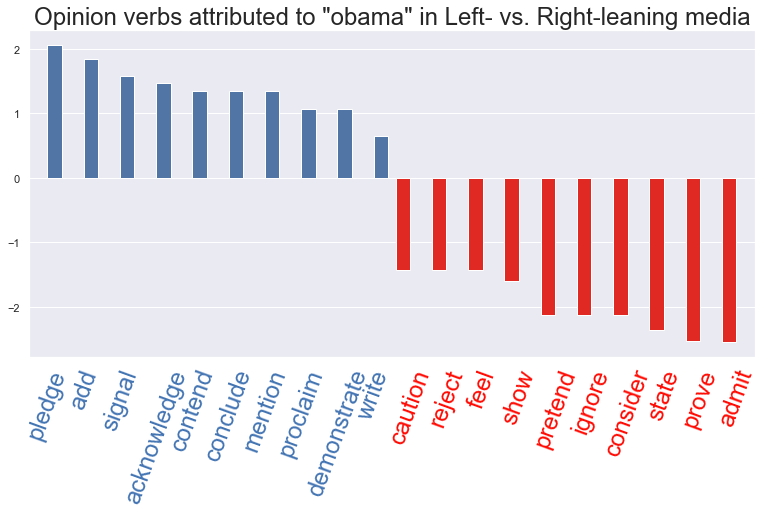

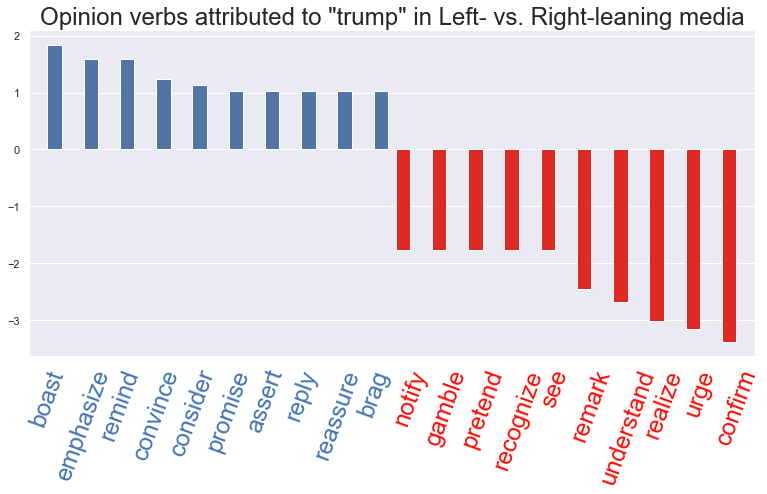

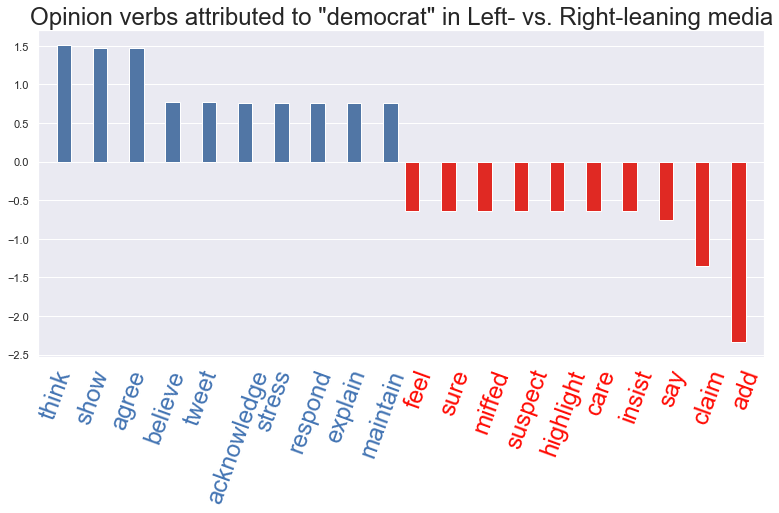

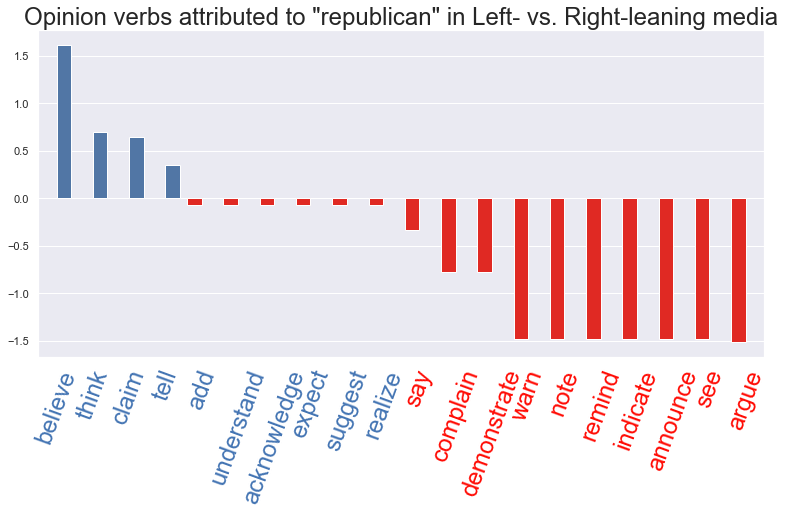

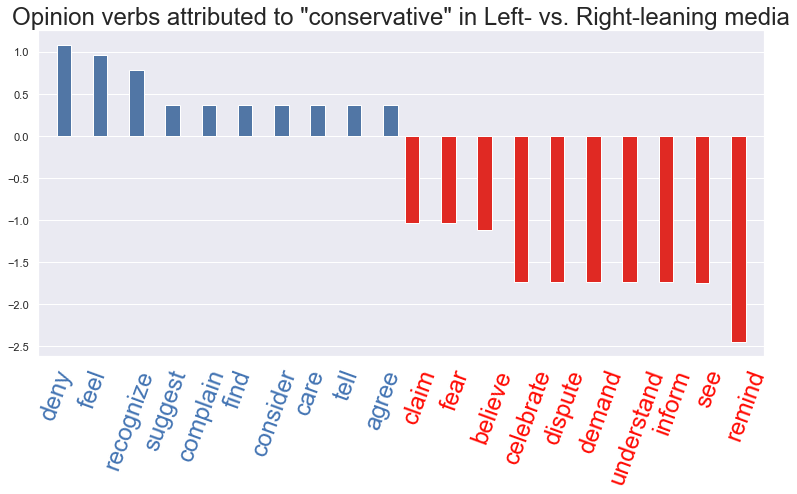

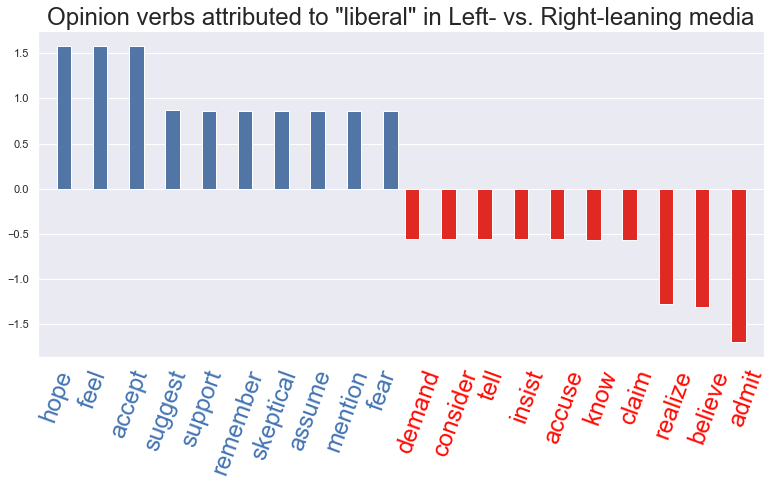

In [580]:
for ent in ent_set:
    verb_df,odds_ratios_df,subject_df,pref_df = [],[],[],[]
    for v,o in sorted_pro_anti_verb_lor[ent][:10]+\
    sorted_pro_anti_verb_lor[ent][-10:]:
        verb_df.append(v)
        odds_ratios_df.append(o)
        subject_df.append(ent)
        pref_df.append(o > 0)
    verb_odds_df = pd.DataFrame({"verb":verb_df,
                                "log odds ratios":odds_ratios_df,
                                "subject":subject_df,
                                "pref":pref_df})
    
    colors = ["#FF0B04","#4374B3"]
    # Set your custom color palette
    sns.set_palette(sns.color_palette(colors))

    fig,ax = plt.subplots(figsize=(13,6))
    sns.barplot(x="verb", y="log odds ratios", data=verb_odds_df, ax=ax, hue='pref')

    ax.set_xticklabels(labels=ax.get_xticklabels(),fontsize=24,rotation=70)
    ax.set_xlabel('')
    ax.set_title('Opinion verbs attributed to "{}" in Left- vs. Right-leaning media'.format(ent),fontsize=24)
    ax.set_ylabel('')
    ax.legend_.remove()

    for tick in ax.get_xticklabels()[:10]: tick.set_color(colors[1])
    for tick in ax.get_xticklabels()[10:]: tick.set_color(colors[0])

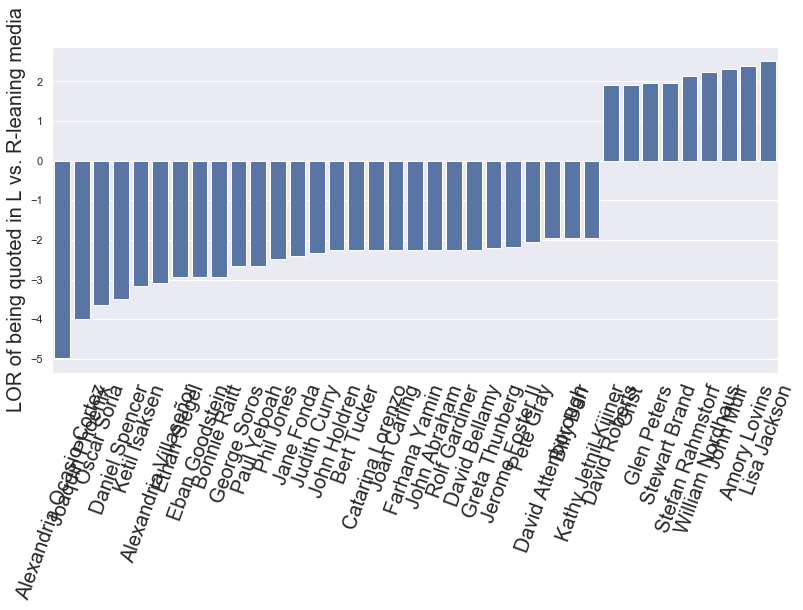

In [419]:
plot_lor_L_R('cc',LONG_CC_ACTIVIST_ENTS)

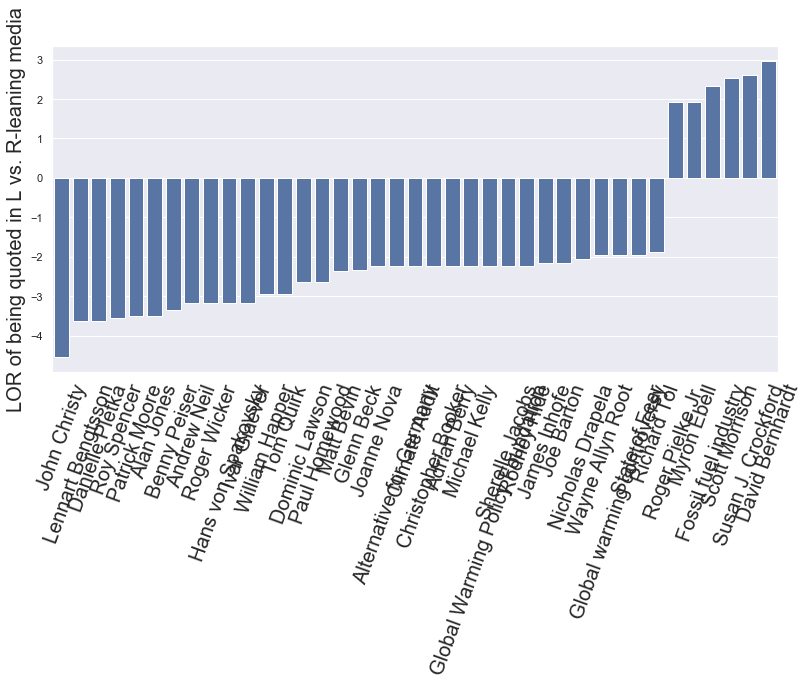

In [549]:
plot_lor_L_R('cc',LONG_CC_SKEPTIC_ENTS)

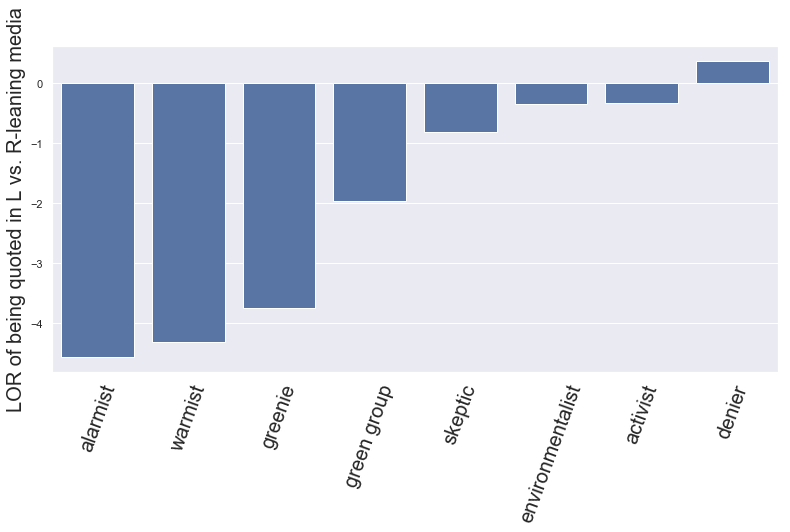

In [421]:
plot_lor_L_R('cc',CC_LABELS,do_small=False)

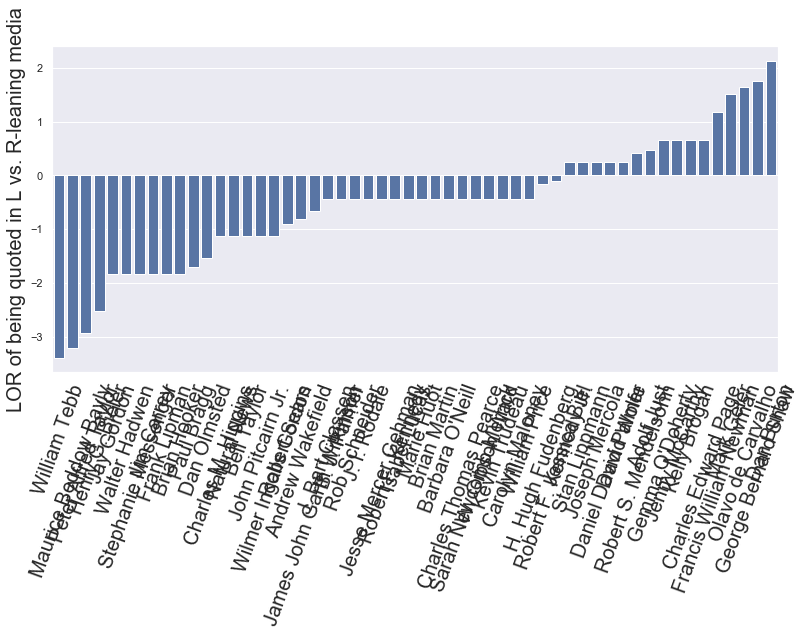

In [429]:
plot_lor_L_R('vax',LONG_ANTI_VAX_ACTIVIST_ENTS,do_small=False)

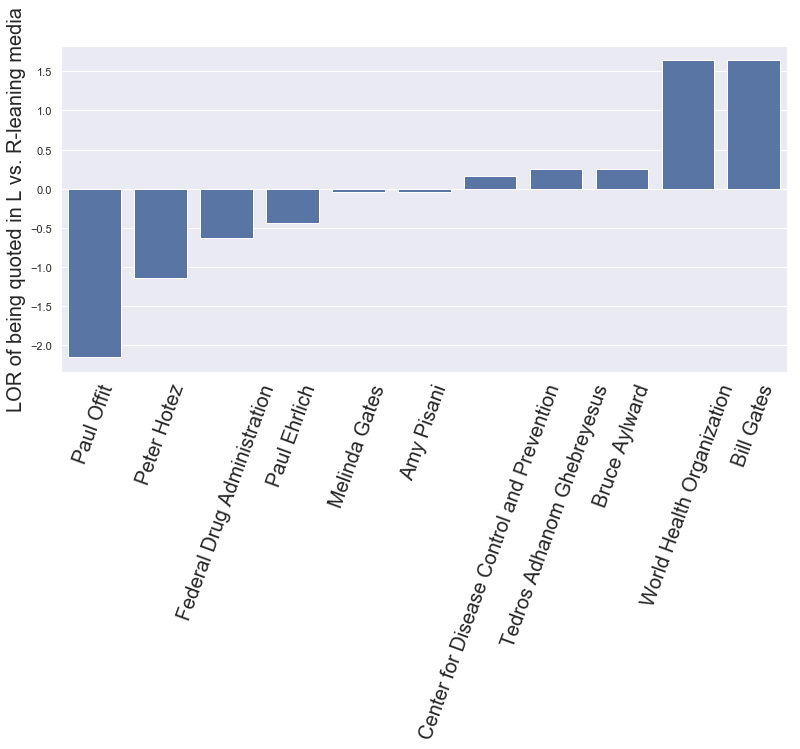

In [430]:
plot_lor_L_R('vax',LONG_PRO_VAX_ACTIVIST_ENTS,do_small=False)

In [570]:
#plot_lor_L_R('vax',VAX_LABELS,do_small=False)

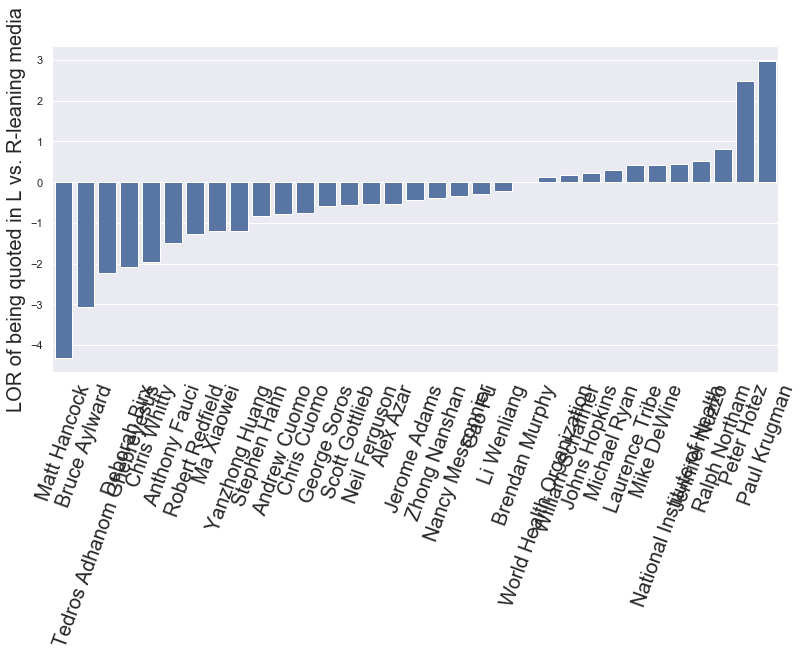

In [432]:
plot_lor_L_R('covid',LONG_COVID_ACTIVIST_ENTS,do_small=False)

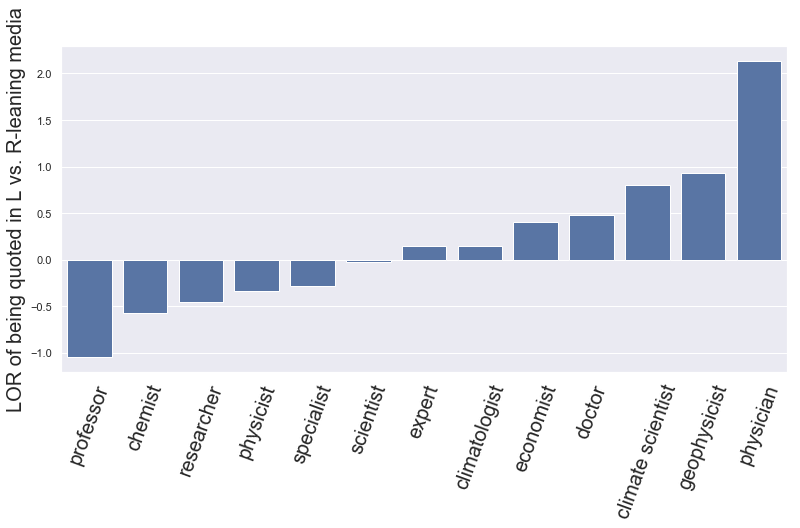

In [567]:
plot_lor_L_R('cc',SCIENTIST_ENTS+['economist'],do_small=False)

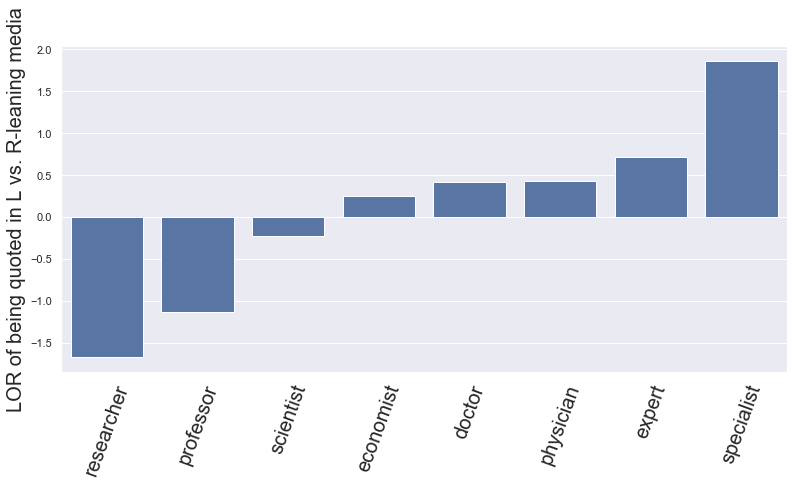

In [568]:
plot_lor_L_R('vax',SCIENTIST_ENTS+['economist'],do_small=False)

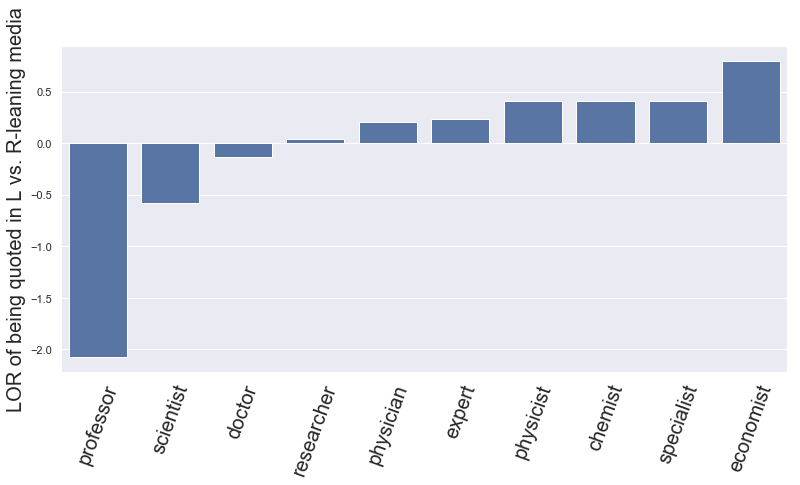

In [569]:
plot_lor_L_R('covid',SCIENTIST_ENTS+['economist'],do_small=False)

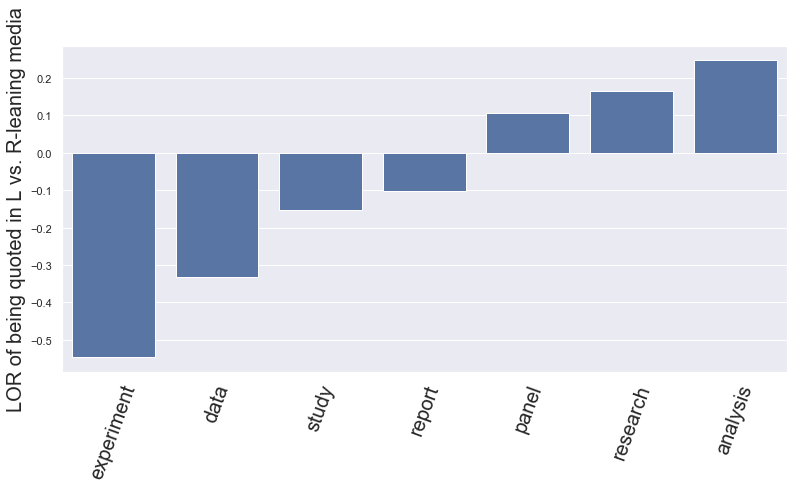

In [423]:
plot_lor_L_R('cc',SCIENCE_ENTS,do_small=False)

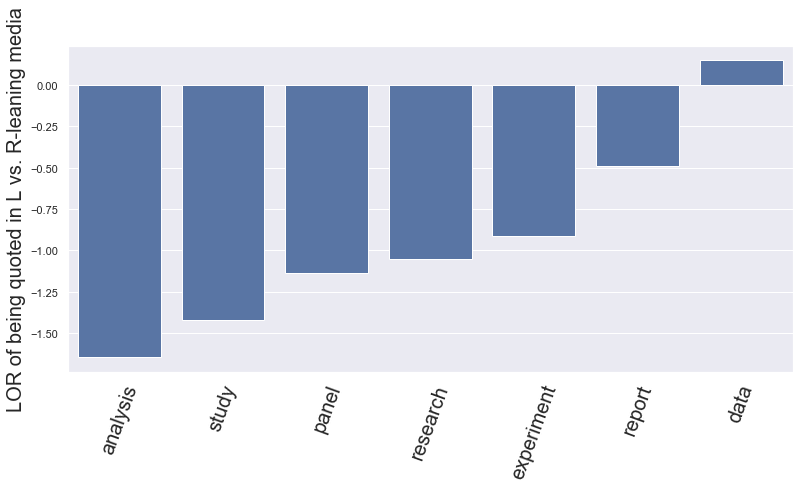

In [426]:
plot_lor_L_R('vax',SCIENCE_ENTS,do_small=False)

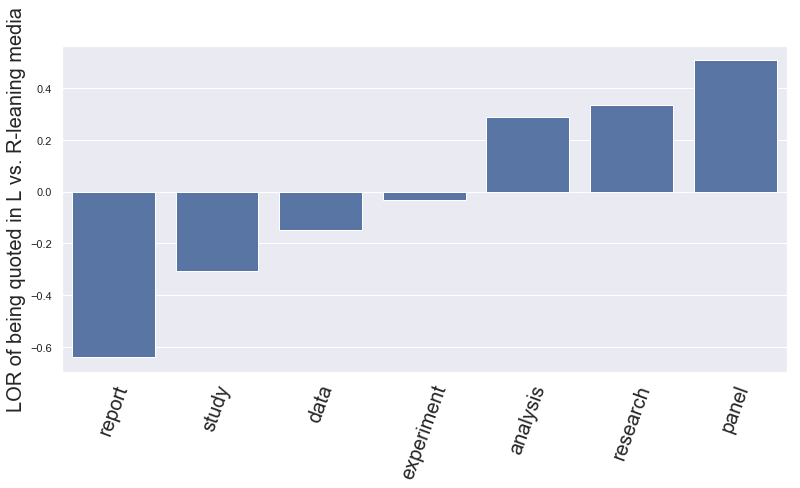

In [427]:
plot_lor_L_R('covid',SCIENCE_ENTS,do_small=False)

cc pro 7655
cc anti 3636
vax pro 569
vax anti 380
covid pro 2756
covid anti 2064


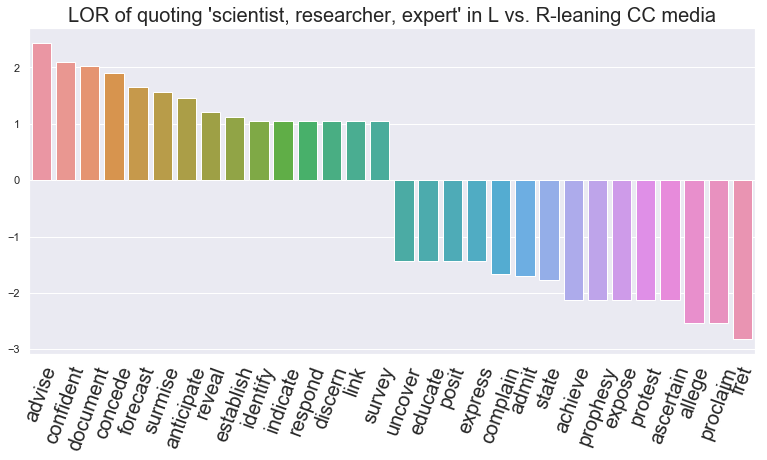

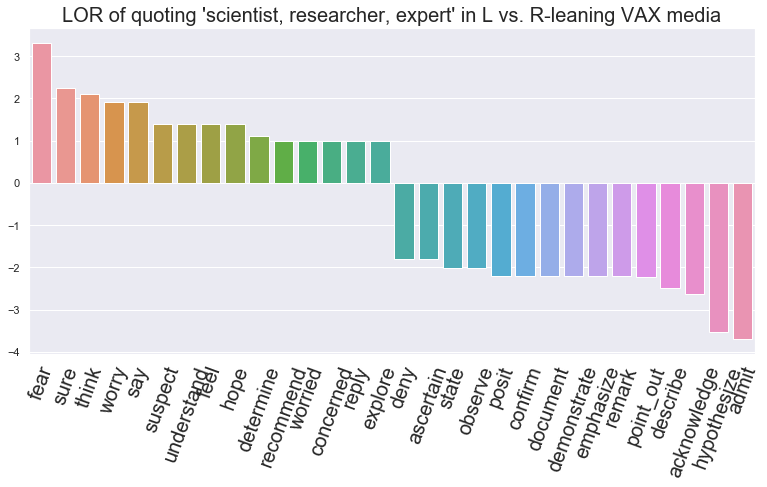

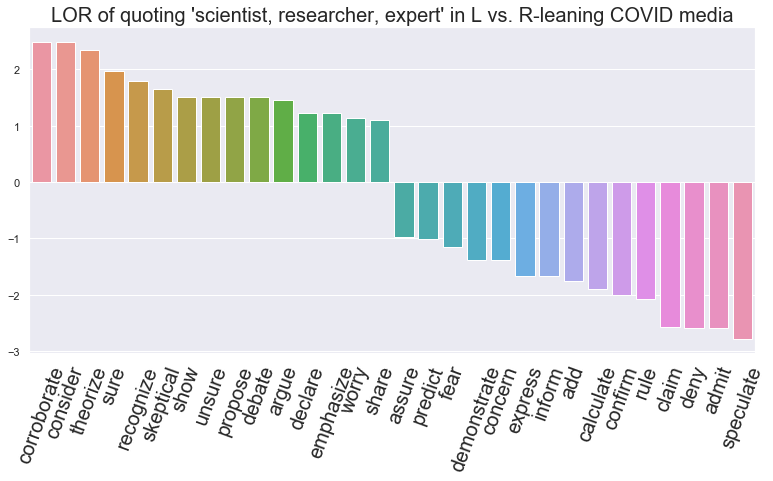

In [574]:
get_verbs_for_subj(['scientist','researcher','expert'])

cc pro 7178
cc anti 3336
vax pro 585
vax anti 627
covid pro 1369
covid anti 1509


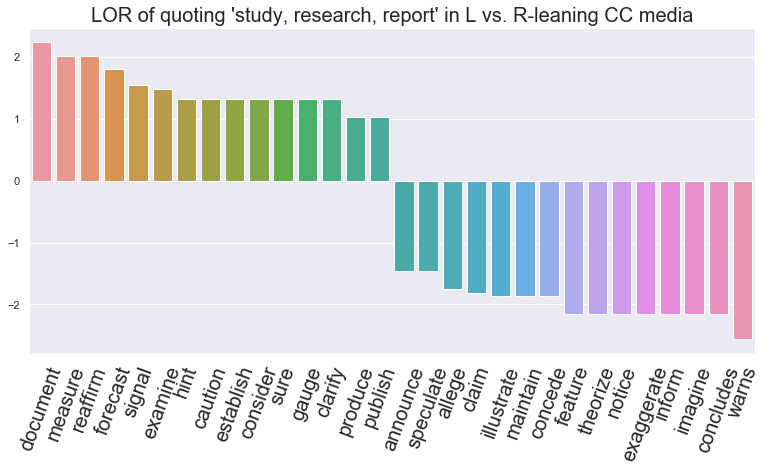

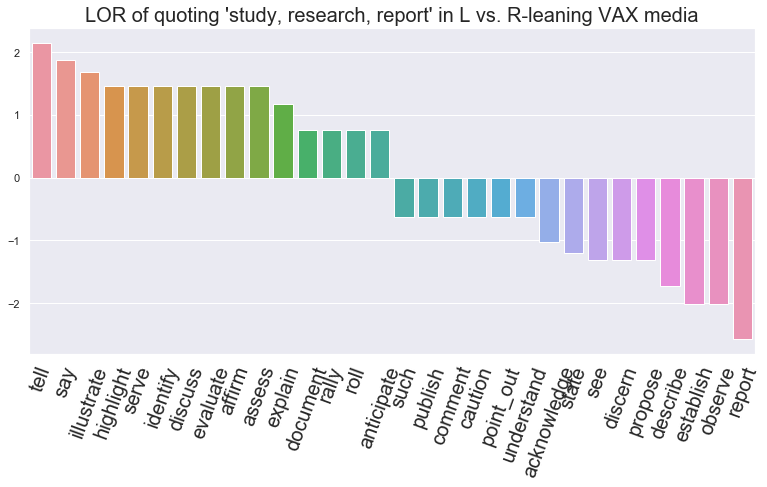

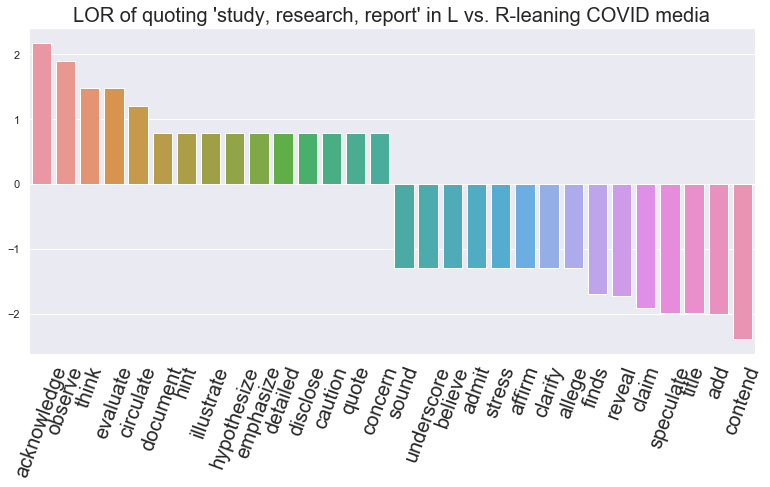

In [573]:
get_verbs_for_subj(['study','research','report'])

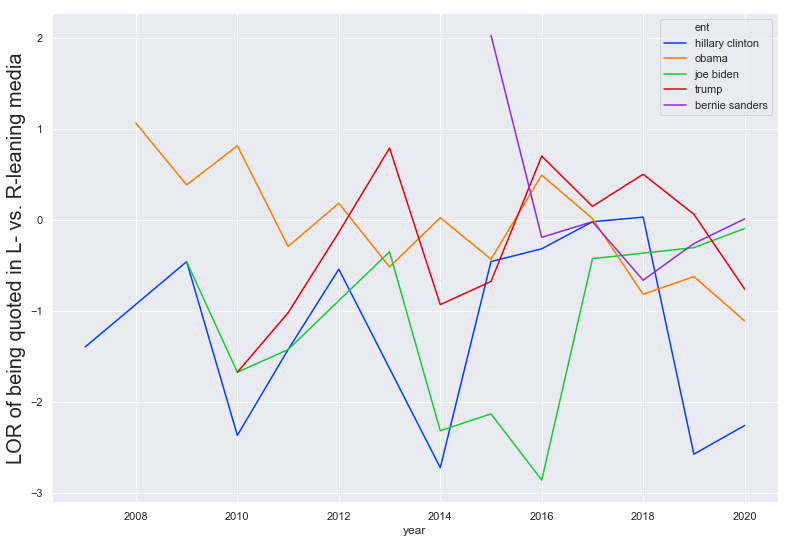

In [345]:
get_subj_ratios_df_over_time(['obama','trump','joe biden','bernie sanders','hillary clinton'])

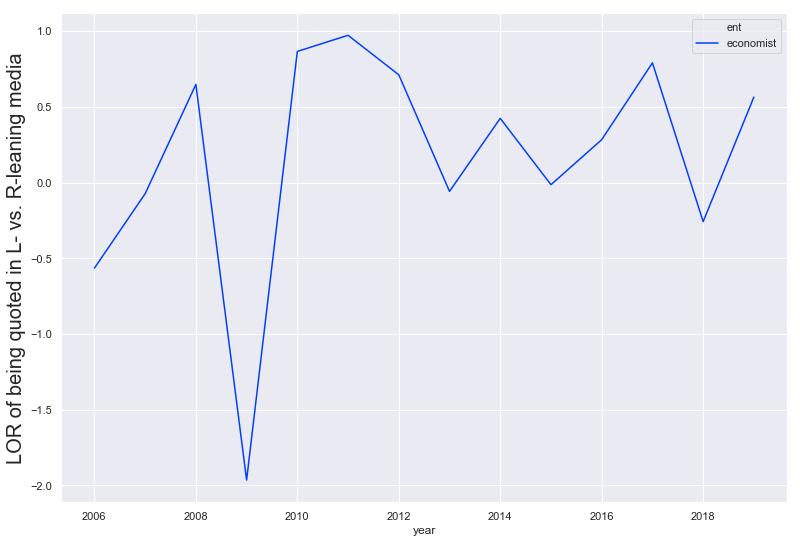

In [352]:
get_subj_ratios_df_over_time(['fox news','new york times'])

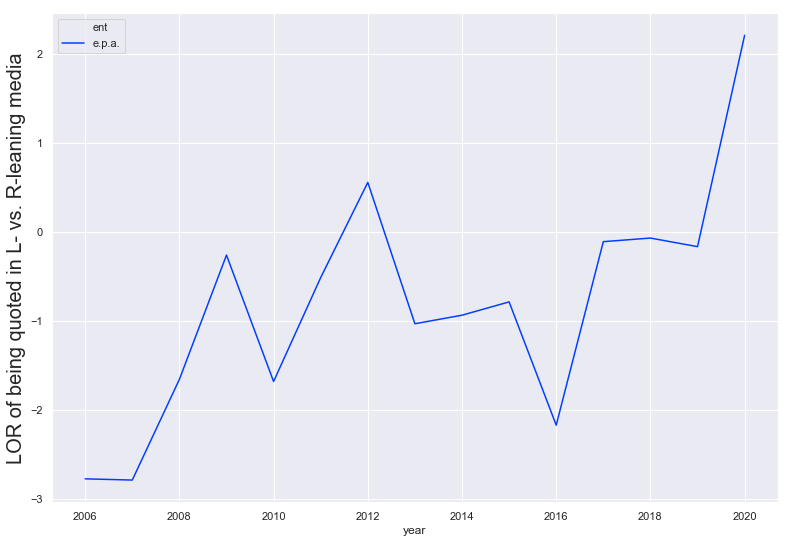

In [346]:
get_subj_ratios_df_over_time(EPA_ENTS)

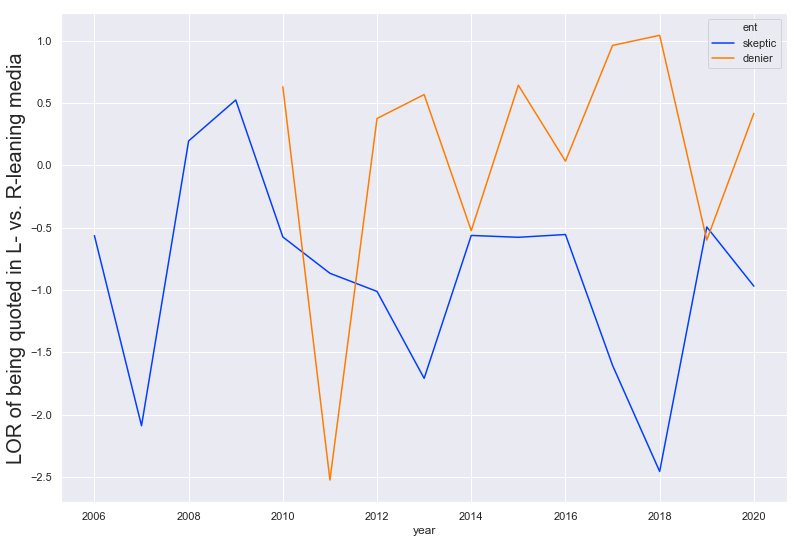

In [341]:
get_subj_ratios_df_over_time(SKEPTIC_ENTS)

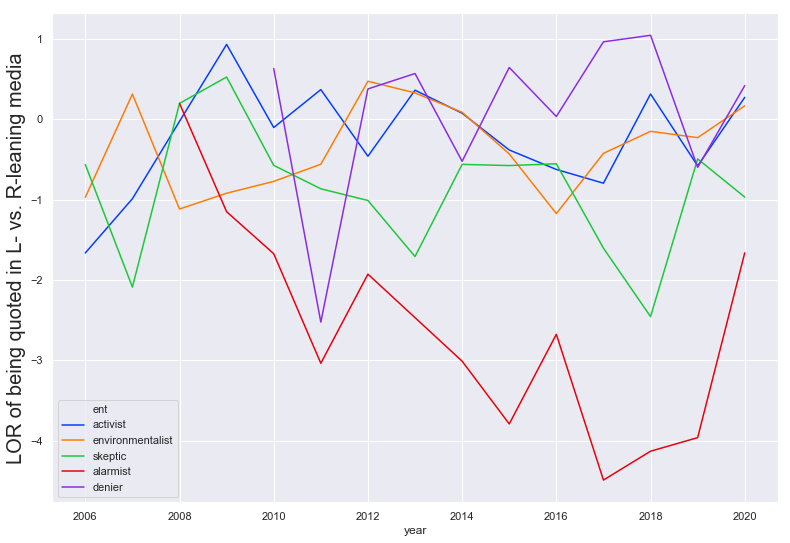

In [340]:
get_subj_ratios_df_over_time(['activist','alarmist','environmentalist','denier','skeptic'])

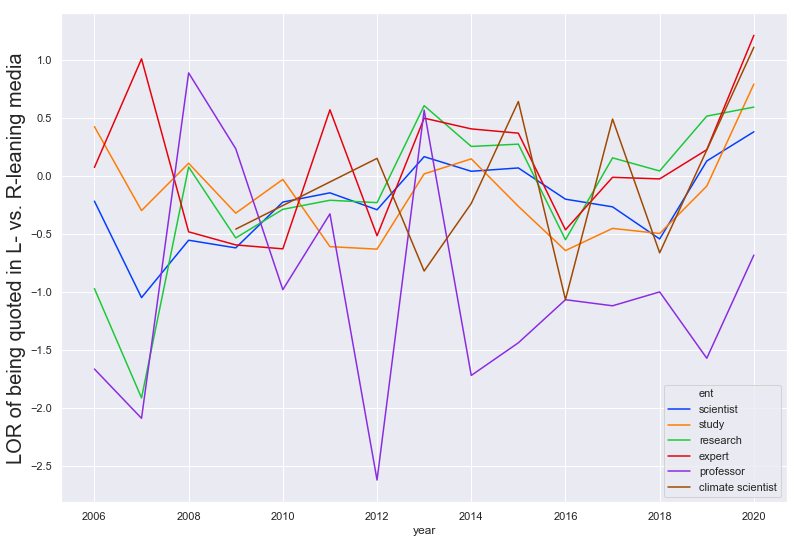

In [338]:
get_subj_ratios_df_over_time(['scientist','study','research','climate scientist','expert','professor'])

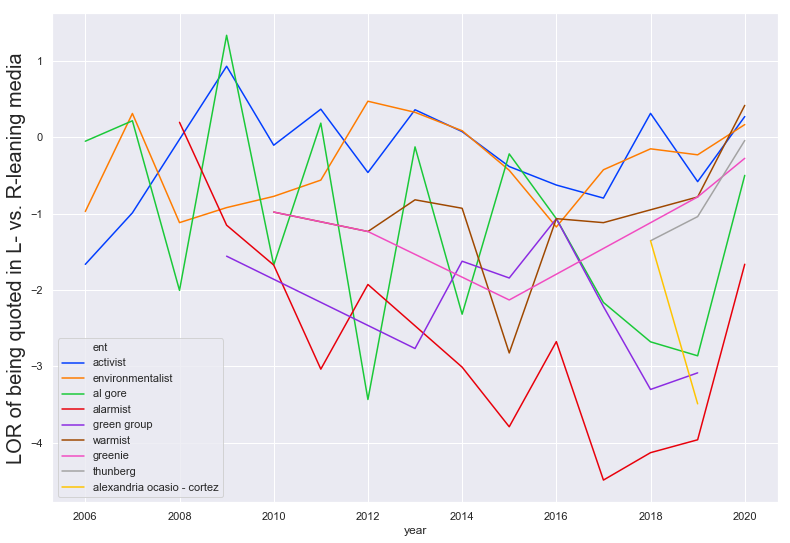

In [342]:
get_subj_ratios_df_over_time(SHORT_ACTIVIST_ENTS)

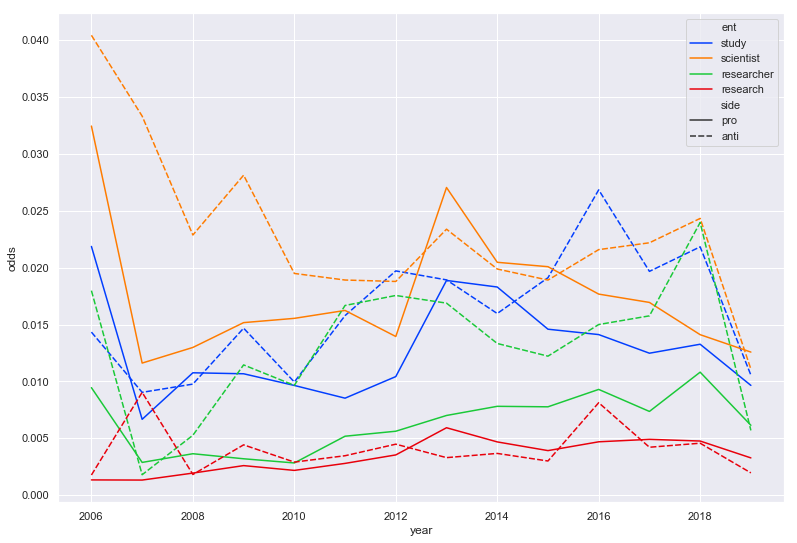

In [658]:
get_subj_df_over_time(['study','scientist','researcher','research'])

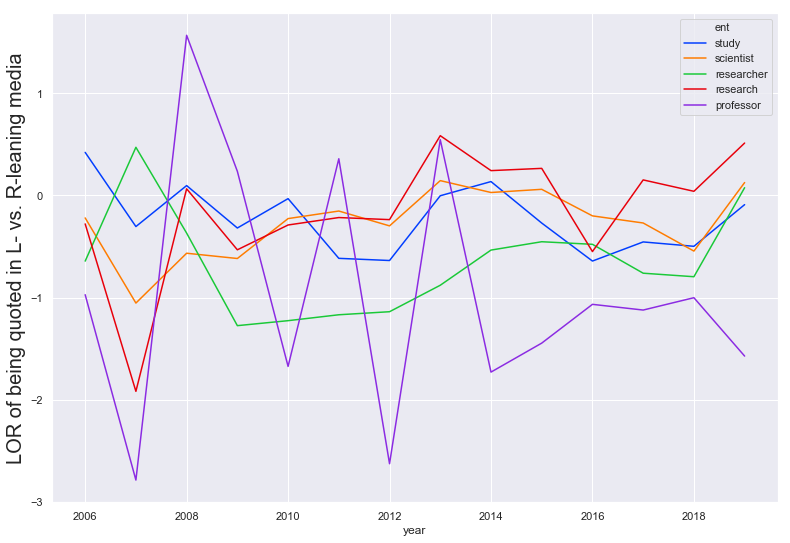

In [662]:
get_subj_ratios_df_over_time(['study','scientist','researcher','research','professor'])

In [289]:
skeptic_df = get_subj_df_over_time(SKEPTIC_ENTS)
scientist_df = get_subj_df_over_time(SCIENTIST_ENTS)
activist_df = get_subj_df_over_time(SHORT_ACTIVIST_ENTS)
science_df = get_subj_df_over_time(SCIENCE_ENTS+SCIENTIST_ENTS)

In [89]:
sci_ents_dict = {topic:{side: {ent: None for ent in ent_set} for side in SIDES} for topic in TOPICS}
for topic in TOPICS:
    for side in SIDES:
        for ent in ent_set:
            qs_from_ent = [q for q in good_quotes if q['stance'] == side and 
                          q['topic'] == topic and 
                           q['main subject lemma coref'] is not None and 
                           q['main subject lemma coref'].lower() == ent]
            print(topic,side,ent,len(qs_from_ent))
            sci_ents_dict[topic][side][ent] = len(qs_from_ent)

cc pro scientist 4121
cc pro researcher 1805
cc pro climate scientist 21
cc pro climatologist 55
cc pro expert 1729
cc pro physicist 22
cc pro economist 325
cc anti scientist 1798
cc anti researcher 1202
cc anti climate scientist 4
cc anti climatologist 20
cc anti expert 636
cc anti physicist 13
cc anti economist 92
vax pro scientist 143
vax pro researcher 169
vax pro climate scientist 0
vax pro climatologist 0
vax pro expert 257
vax pro physicist 0
vax pro economist 4
vax anti scientist 58
vax anti researcher 281
vax anti climate scientist 0
vax anti climatologist 0
vax anti expert 41
vax anti physicist 0
vax anti economist 1


In [92]:
ents_df,sides_df,counts_df,freqs_df,odds_df = [],[],[],[],[]
for side in sci_ents_dict['cc']:
    for ent in sci_ents_dict['cc'][side]:
        ents_df.append(ent)
        sides_df.append(side)
        counts_df.append(sci_ents_dict['cc'][side][ent])
        freq = sci_ents_dict['cc'][side][ent]/np.sum([sci_ents_dict['cc'][side][ent] 
                                                              for ent in sci_ents_dict['cc'][side]])
        freqs_df.append(freq)
        odds_df.append(freq/(1-freq))
ent_df = pd.DataFrame({'ent':ents_df,
             'side':sides_df,
             'count':counts_df,
             'freq':freqs_df,
             'odds':odds_df})

# Case study: Most common opinion attribution verbs for Trump and Obama, dems vs. reps (sanity check)

In [576]:
ent_set = ['obama','trump','democrat','republican','conservative','liberal']

In [577]:
main_verbs_by_ent = {topic:{side: {ent: None for ent in ent_set} for side in SIDES} for topic in TOPICS}
for topic in ['cc','covid']:#TOPICS:
    for side in SIDES:
        for ent in ent_set:
            qs_from_ent = [q for q in all_quotes if q['stance'] == side and 
                          q['topic'] == topic and 
                           q['main subject lemma coref'] is not None and 
                           q['main subject lemma coref'].lower() == ent]
            print(topic,side,ent,len(qs_from_ent))
            main_verbs = [q['main verb lemma coref'].lower() for q in qs_from_ent]
            main_verbs_by_ent[topic][side][ent] = main_verbs

cc pro obama 725
cc pro trump 1609
cc pro democrat 50
cc pro republican 60
cc pro conservative 139
cc pro liberal 37
cc anti obama 348
cc anti trump 556
cc anti democrat 53
cc anti republican 28
cc anti conservative 50
cc anti liberal 43
covid pro obama 26
covid pro trump 2223
covid pro democrat 15
covid pro republican 17
covid pro conservative 14
covid pro liberal 5
covid anti obama 13
covid anti trump 1068
covid anti democrat 17
covid anti republican 19
covid anti conservative 12
covid anti liberal 13


In [578]:
pro_anti_verb_lor = {}
for ent in ent_set:
    pro_anti_verb_lor[ent] = do_log_odds(main_verbs_by_ent['cc']['pro'][ent],
                                                     main_verbs_by_ent['cc']['anti'][ent],
                                         blacklist_set=BLACKLIST_VERBS,ratios=True)

In [579]:
sorted_pro_anti_verb_lor = {}
for ent in ent_set:
    sorted_pro_anti_verb_lor[ent] = sorted(pro_anti_verb_lor[ent].items(),
                                                    key=lambda x:x[1],reverse=True)

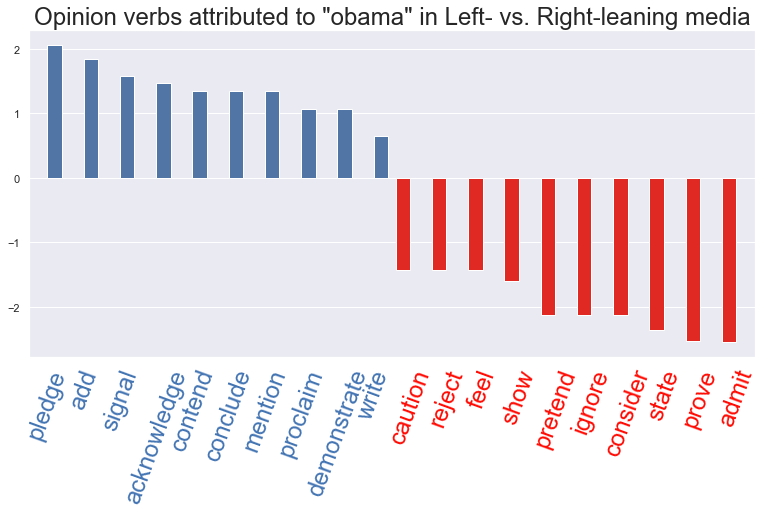

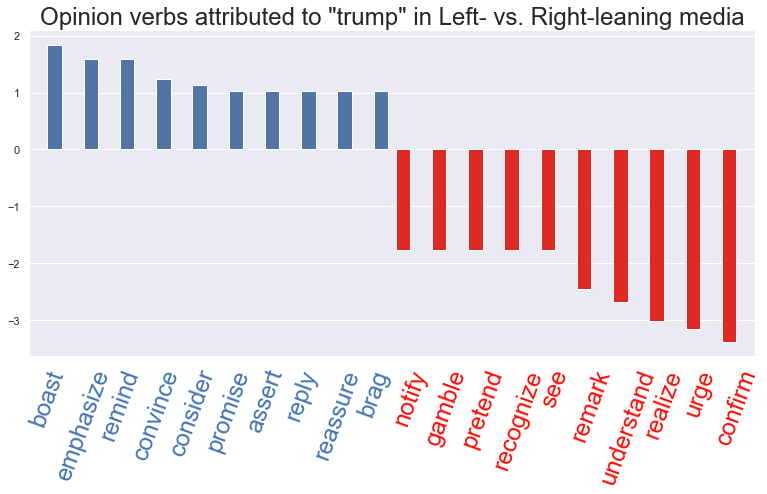

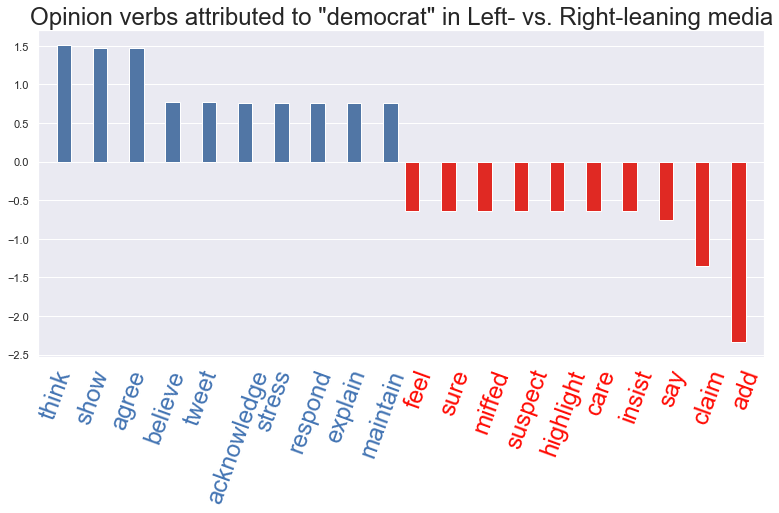

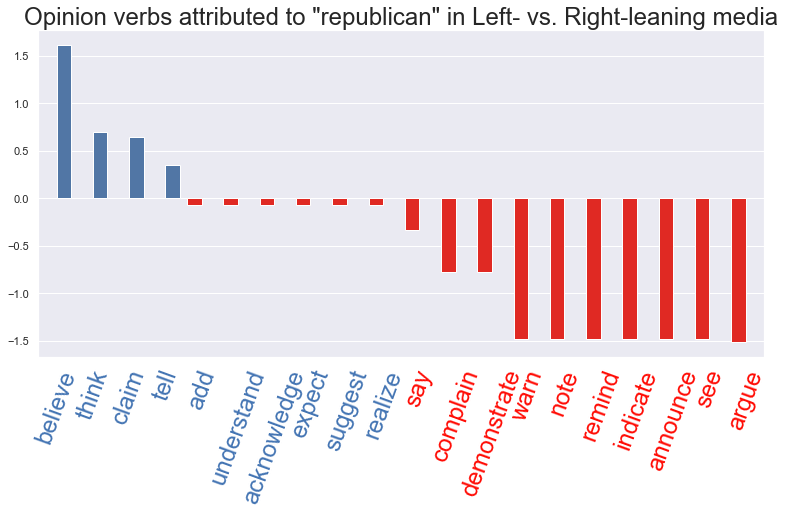

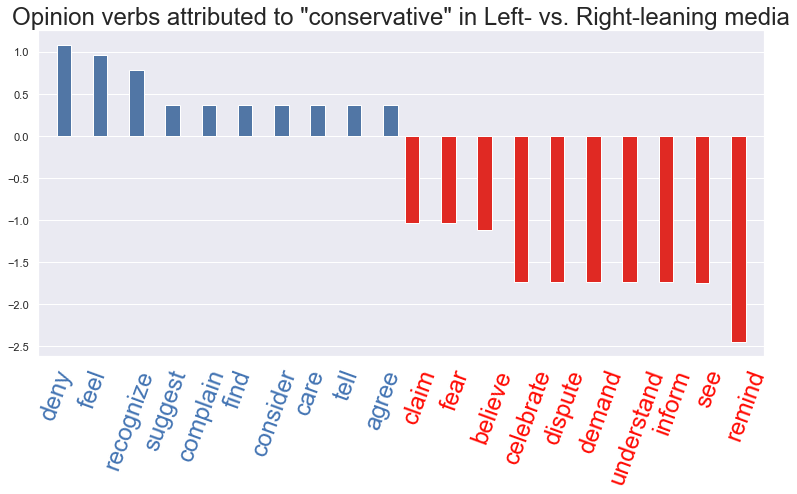

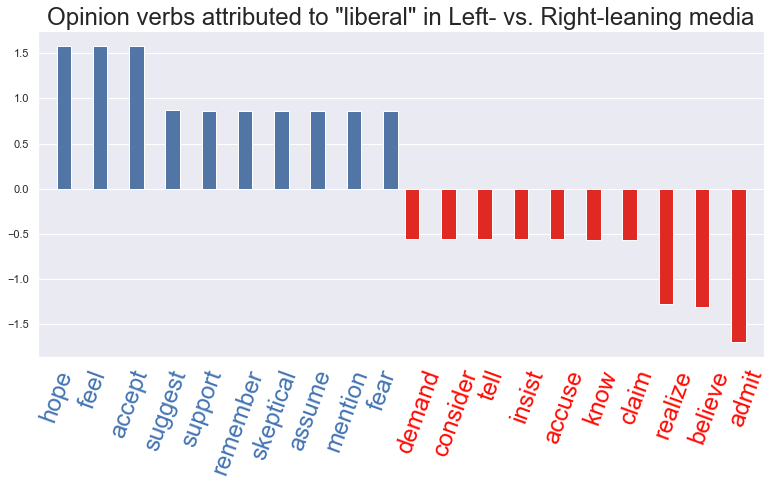

In [547]:
for ent in ent_set:
    verb_df,odds_ratios_df,subject_df,pref_df = [],[],[],[]
    for v,o in sorted_pro_anti_verb_lor[ent][:10]+\
    sorted_pro_anti_verb_lor[ent][-10:]:
        verb_df.append(v)
        odds_ratios_df.append(o)
        subject_df.append(ent)
        pref_df.append(o > 0)
    verb_odds_df = pd.DataFrame({"verb":verb_df,
                                "log odds ratios":odds_ratios_df,
                                "subject":subject_df,
                                "pref":pref_df})
    
    colors = ["#FF0B04","#4374B3"]
    # Set your custom color palette
    sns.set_palette(sns.color_palette(colors))

    fig,ax = plt.subplots(figsize=(13,6))
    sns.barplot(x="verb", y="log odds ratios", data=verb_odds_df, ax=ax, hue='pref')

    ax.set_xticklabels(labels=ax.get_xticklabels(),fontsize=24,rotation=70)
    ax.set_xlabel('')
    ax.set_title('Opinion verbs attributed to "{}" in Left- vs. Right-leaning media'.format(ent),fontsize=24)
    ax.set_ylabel('')
    ax.legend_.remove()

    for tick in ax.get_xticklabels()[:10]: tick.set_color(colors[1])
    for tick in ax.get_xticklabels()[10:]: tick.set_color(colors[0])

# Case study: Log odds of words in quotes from scientists in L vs. R-wing media

In [353]:
SCIENTIST_SOURCES = SCIENTIST_ENTS
SCIENTIST_SOURCES

['scientist',
 'researcher',
 'climate scientist',
 'climatologist',
 'expert',
 'physicist',
 'economist',
 'professor',
 'geophysicist',
 'chemist',
 'specialist',
 'panel']

In [498]:
scientist_quotes = defaultdict(dict)
for topic in TOPICS:
    for side in SIDES:
        scientist_quotes[topic][side] = [q for q in quotes_by_topic_side[topic][side] if q['main subject lemma coref'] is not None and \
                        (q['main subject lemma coref'].lower() in ['alarmist'] or \
                       q['main subject text'].lower() in ['alarmist'] or \
                        (q['main subject lemma coref'].lower() in ent_fuzzy_map and \
                         ent_fuzzy_map[q['main subject lemma coref'].lower()] in ['alarmist']))]
        print(topic,side,len(scientist_quotes[topic][side]))

cc pro 3
cc anti 123
vax pro 0
vax anti 0
covid pro 0
covid anti 1


In [499]:
anti_sci_quote_toks = [q['quote lemmas'] for q in anti_scientist_quotes]
pro_sci_quote_toks = [q['quote lemmas'] for q in pro_scientist_quotes]
anti_sci_quote_toks = [item.lower() for sublist in anti_sci_quote_toks for item in sublist]
pro_sci_quote_toks = [item.lower() for sublist in pro_sci_quote_toks for item in sublist]
len(pro_sci_quote_toks),len(anti_sci_quote_toks)

(164724, 81402)

In [30]:
log_odds_ratios_pro_anti_sci_quotes = do_log_odds(pro_sci_quote_toks,anti_sci_quote_toks)

In [31]:
sorted(log_odds_ratios_pro_anti_sci_quotes.items(),key=lambda x:x[1],reverse=True)[-100:]

[('450', -1.7566411849483894),
 ('swamp', -1.7566411849483894),
 ('error', -1.7566411849483894),
 ('plain', -1.7566411849483894),
 ('telescope', -1.7566411849483894),
 ('forecasting', -1.7566411849483894),
 ('exciting', -1.7566411849483894),
 ('door', -1.7566411849483894),
 ('quieter', -1.7566411849483894),
 ('#', -1.7566411849483894),
 ('caribbean', -1.7566411849483894),
 ('outer', -1.7566411849483894),
 ('crowd', -1.7566411849483894),
 ('cod', -1.7566411849483894),
 ('origin', -1.7566411849483894),
 ('compile', -1.7566411849483894),
 ('58', -1.7566411849483894),
 ('tectonic', -1.7566411849483894),
 ('mobile', -1.7566411849483894),
 ('sahara', -1.7566411849483894),
 ('installation', -1.7566411849483894),
 ('fukushima', -1.7566411849483894),
 ('productive', -1.7566411849483894),
 ('mitigation', -1.7566411849483894),
 ('book', -1.7566868936177982),
 ('thick', -1.7566868936177982),
 ('1998', -1.7566868936177982),
 ('operate', -1.7566868936177982),
 ('limited', -1.7566868936177982),
 ('th

# Case study: Log odds of op. attr. verbs for scientists in L vs. R-wing media

In [500]:
topic_side_sci_verb_toks = defaultdict(dict)
for topic in TOPICS:
    for side in SIDES:
        topic_side_sci_verb_toks[topic][side] = [q['main verb lemma'].lower() 
                                                 for q in scientist_quotes[topic][side]]

In [507]:
topic_sci_verb_log_odds_ratios_pro_anti = {}
for topic in ['cc']:
    topic_sci_verb_log_odds_ratios_pro_anti[topic] = do_log_odds(topic_side_sci_verb_toks[topic]['pro'],
                                                                 topic_side_sci_verb_toks[topic]['anti'])

In [505]:
topic_side_sci_verb_toks['cc']['pro']

['acknowledge', 'suggest', 'say']

In [510]:
topic_sci_verb_sorted_lor_pro_anti = {}
for topic in ['cc']:
     topic_sci_verb_sorted_lor_pro_anti[topic] = sorted(topic_sci_verb_log_odds_ratios_pro_anti[topic].items(),
                                                        key=lambda x:x[1],reverse=True)

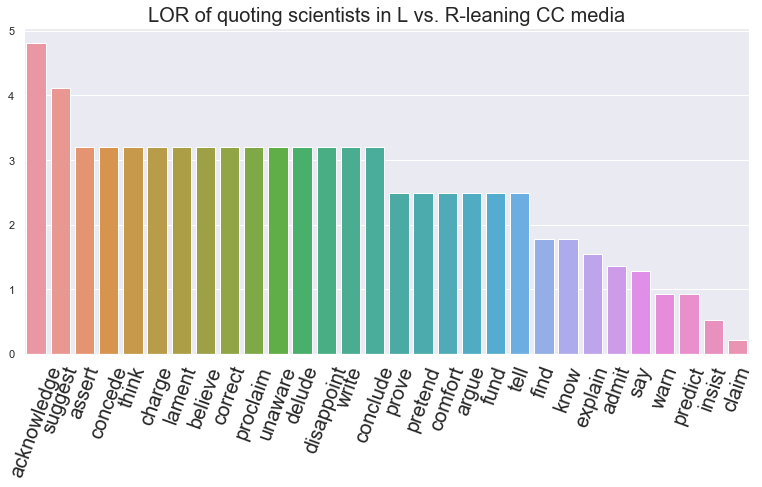

In [511]:
for topic in ['cc']:
    verb_df,lor_df = [],[]
    for item in topic_sci_verb_sorted_lor_pro_anti[topic][:15]+\
    topic_sci_verb_sorted_lor_pro_anti[topic][-15:]:
        v = item[0]
        lor = item[1]
        verb_df.append(v)
        lor_df.append(lor)
    subj_verb_df =pd.DataFrame({"verb":verb_df,
                               "log_odds_ratio":lor_df})
    fig,ax=plt.subplots(figsize=(13,6))
    sns.barplot(x='verb',y='log_odds_ratio',data=subj_verb_df,ax=ax)
    ax.set_xticklabels(subj_verb_df.verb.values,rotation=70,fontsize=20)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title("LOR of quoting scientists in L vs. R-leaning {} media".format(topic.upper()),fontsize=20)

Stratified by the type of scientist entity:

In [439]:
def get_verbs_for_subj(subj_set,topic_set=TOPICS,get_df=False):
    subj_quotes = defaultdict(dict)
    for topic in topic_set:
        for side in SIDES:
            subj_quotes[topic][side] = [q for q in quotes_by_topic_side[topic][side] if q['main subject lemma coref'] is not None and \
                            (q['main subject lemma coref'].lower() in subj_set or \
                           q['main subject text'].lower() in subj_set or \
                            (q['main subject lemma coref'].lower() in ent_fuzzy_map and \
                             ent_fuzzy_map[q['main subject lemma coref'].lower()] in subj_set))]
            print(topic,side,len(subj_quotes[topic][side]))
            
    topic_side_subj_verb_toks = defaultdict(dict)
    for topic in topic_set:
        for side in SIDES:
            topic_side_subj_verb_toks[topic][side] = [q['main verb lemma'].lower() 
                                                     for q in subj_quotes[topic][side]]
            
    topic_subj_verb_log_odds_ratios_pro_anti = {}
    for topic in topic_set:
        topic_subj_verb_log_odds_ratios_pro_anti[topic] = do_log_odds(topic_side_subj_verb_toks[topic]['pro'],
                                                                     topic_side_subj_verb_toks[topic]['anti'],
                                                                     blacklist_set=BLACKLIST_VERBS)
        
    topic_subj_verb_sorted_lor_pro_anti = {}
    for topic in topic_set:
         topic_subj_verb_sorted_lor_pro_anti[topic] = sorted(topic_subj_verb_log_odds_ratios_pro_anti[topic].items(),
                                                            key=lambda x:x[1],reverse=True)

    subj_verb_dfs = {}
    for topic in topic_set:
        verb_df,lor_df = [],[]
        for item in topic_subj_verb_sorted_lor_pro_anti[topic][:15]+\
        topic_subj_verb_sorted_lor_pro_anti[topic][-15:]:
            v = item[0]
            lor = item[1]
            verb_df.append(v)
            lor_df.append(lor)
        subj_verb_df = pd.DataFrame({"verb":verb_df,
                                   "log_odds_ratio":lor_df})
        subj_verb_dfs[topic] = subj_verb_df
        fig,ax=plt.subplots(figsize=(13,6))
        sns.barplot(x='verb',y='log_odds_ratio',data=subj_verb_df,ax=ax)
        ax.set_xticklabels(subj_verb_df.verb.values,rotation=70,fontsize=20)
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_title("LOR of quoting '{}' in L vs. R-leaning {} media".format(', '.join(subj_set),topic.upper()),
                     fontsize=20)
        
    if get_df:
        return subj_verb_dfs

cc pro 64
cc anti 175


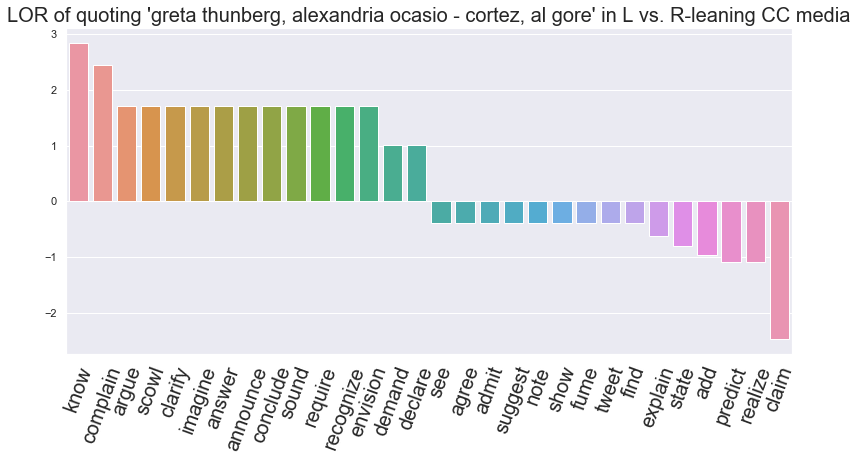

In [572]:
get_verbs_for_subj(['greta thunberg','alexandria ocasio - cortez','al gore'],topic_set=['cc'],get_df=False)

cc pro 7178
cc anti 3336
vax pro 585
vax anti 627
covid pro 1369
covid anti 1509


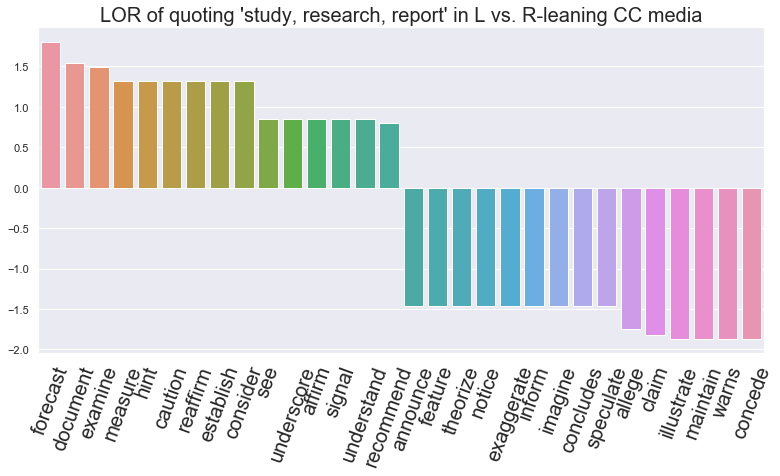

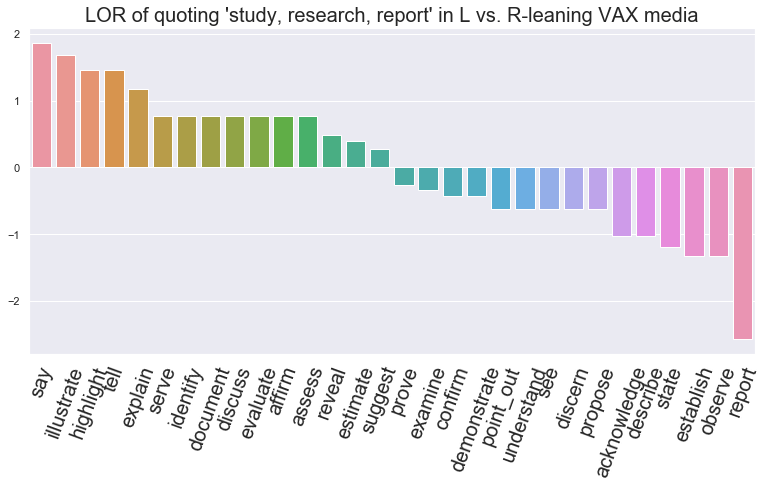

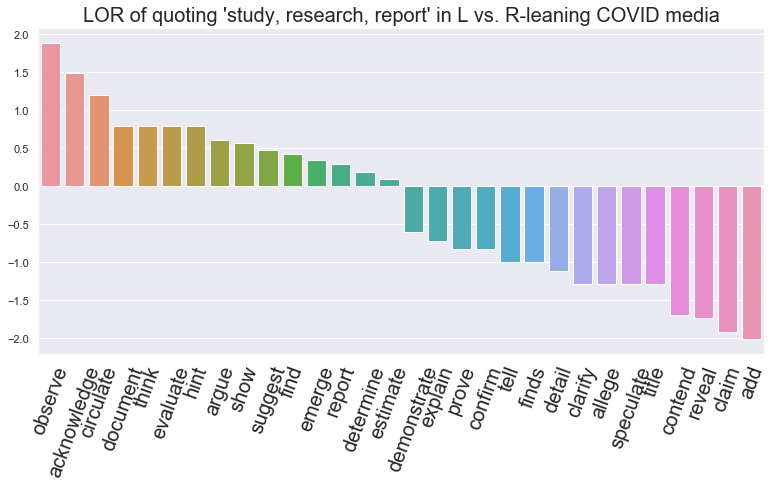

In [487]:
get_verbs_for_subj(['study','research','report'])

cc pro 1729
cc anti 636
vax pro 257
vax anti 41
covid pro 1744
covid anti 1045


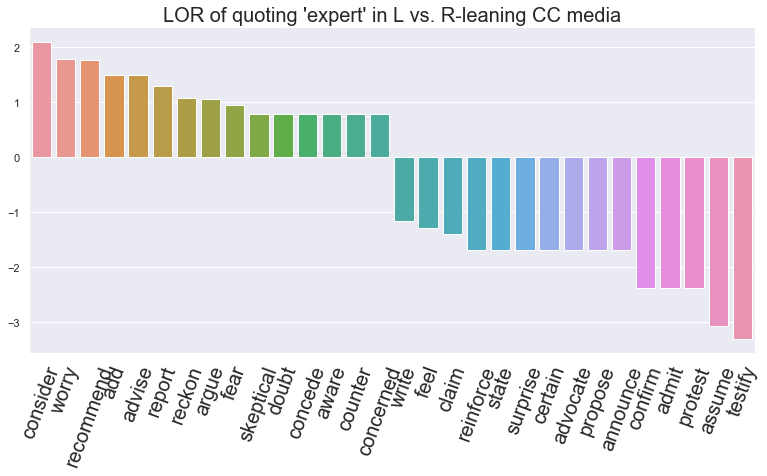

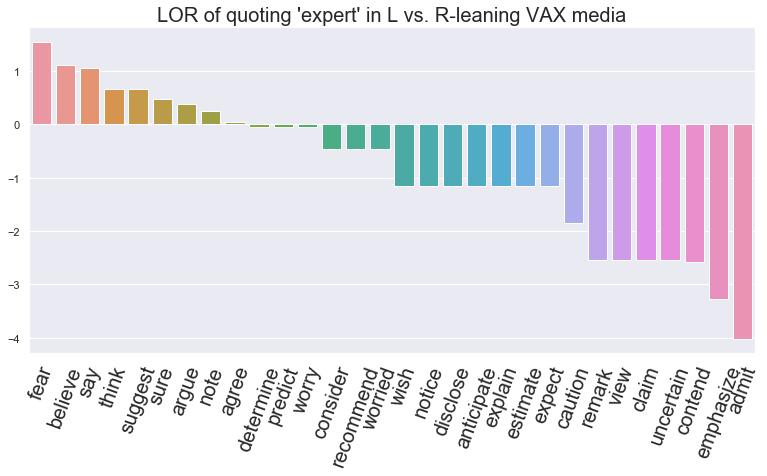

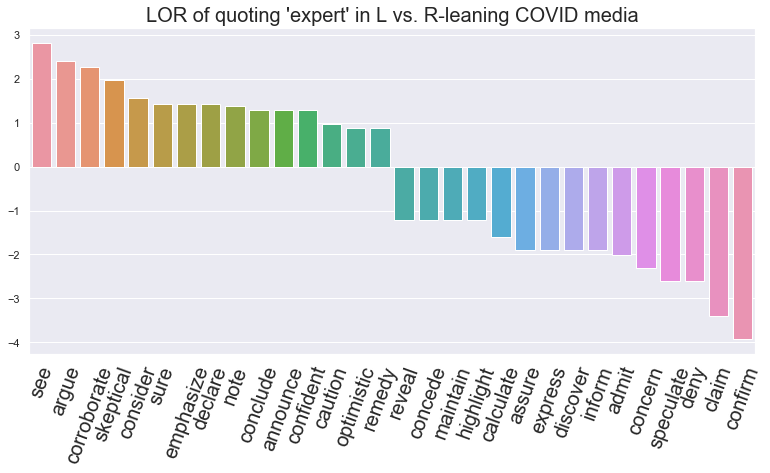

In [553]:
get_verbs_for_subj(['expert'])

cc pro 325
cc anti 92
covid pro 174
covid anti 59


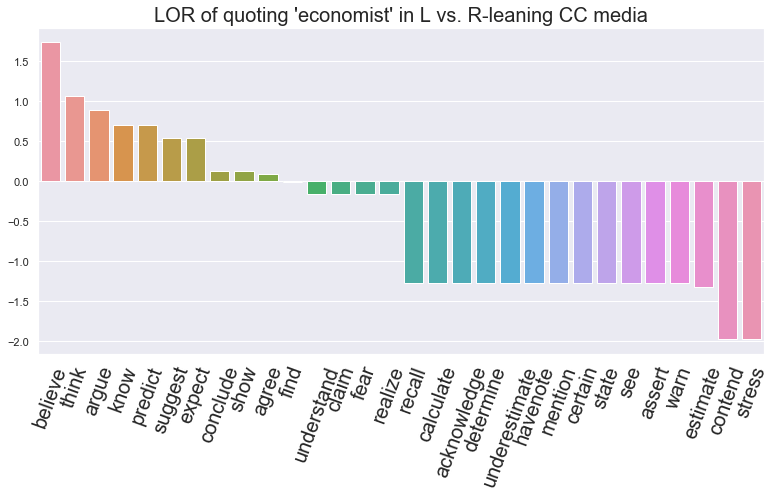

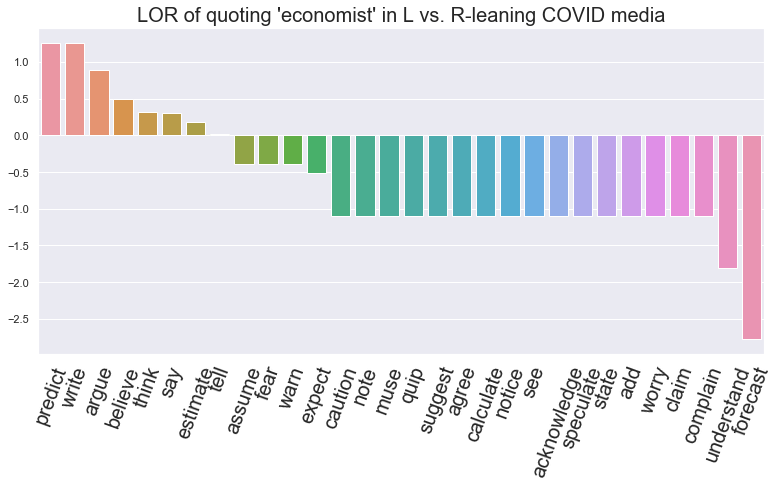

In [488]:
get_verbs_for_subj(['economist'],topic_set=['cc','covid'])

cc pro 5926
cc anti 3000
vax pro 312
vax anti 339
covid pro 1012
covid anti 1019


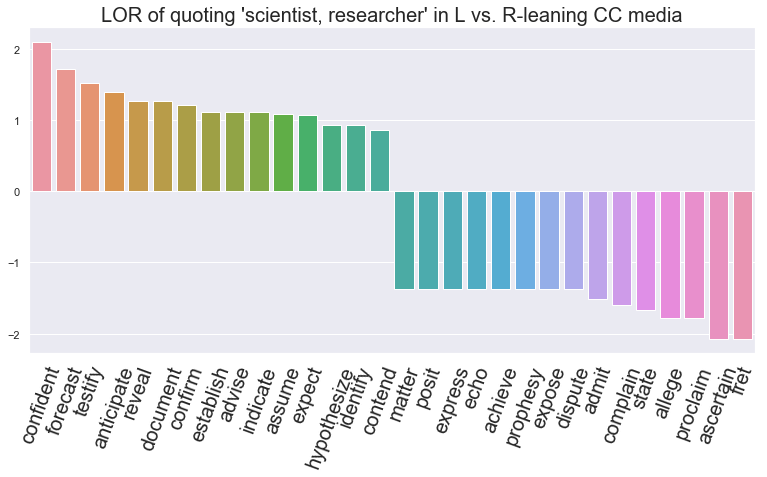

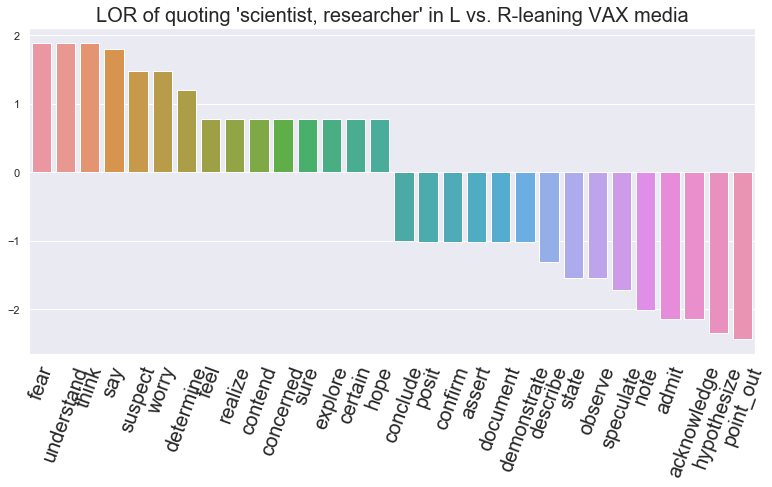

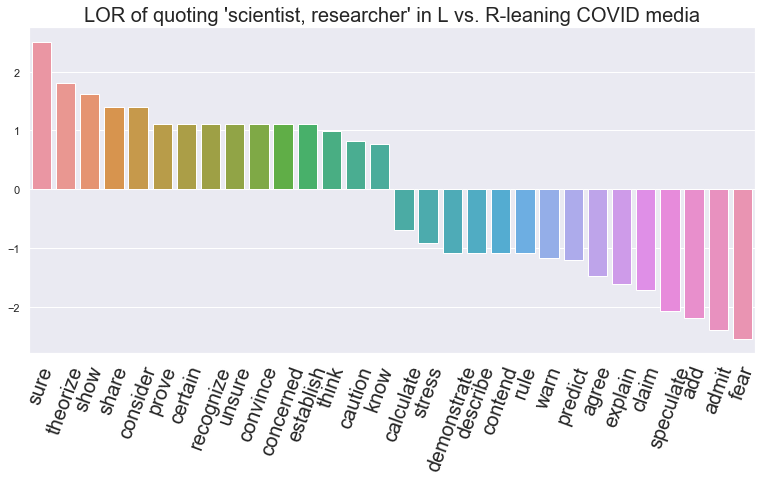

In [489]:
get_verbs_for_subj(['scientist','researcher','expert'])

cc pro 76
cc anti 24


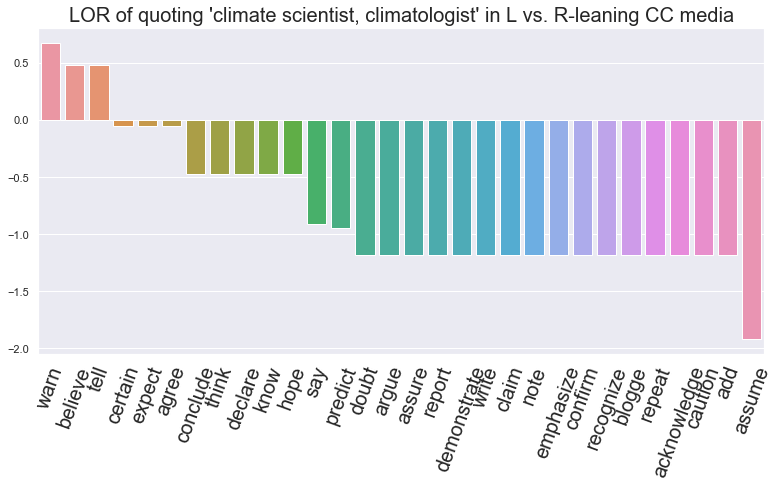

In [490]:
get_verbs_for_subj(['climate scientist','climatologist'],topic_set=['cc'])

## Is odds of verb being attributed to scientist inversely correlated with odds of being attributed to economist?

In [25]:
SCIENTIST_ENTS = set(SCIENTIST_ENTS)

In [456]:
ECONOMIST_ENTS = set([e.lower() for e in ECONOMIST_ENTS])

In [457]:
ECONOMIST_ENTS

{'aloulou fawzi',
 'andy critchlow',
 'bjorn lomborg',
 'chris costello',
 'clive hamilton',
 'david kreutzer',
 'economist',
 'eli berman',
 'frederick chen',
 'gary cohn',
 'gordon hughes',
 'jerome powell',
 'john felmy',
 'john m. reilly',
 'john newton',
 'keith collins',
 'laurence boone',
 'louis p. cain',
 'lucas chancel',
 'marc hafstead',
 'mark perry',
 'marshall burke',
 'matt ridley',
 'nicholas stern',
 'paul romer',
 'peter dorman',
 'peter navarro',
 'peter sheehan',
 'rachel cleetus',
 'richard tol',
 'robert gordon',
 'robert h. frank',
 'robert murphy',
 'robert pindyck',
 'robert stavins',
 'robert w. godby',
 'roger h. bezdek',
 'ross garnaut',
 'samuel h. williamson',
 'stephen moore',
 'thomas piketty',
 'william nordhaus',
 'william stanley jevons'}

In [443]:
scientist_quotes = defaultdict(dict)
for topic in TOPICS:
    for side in SIDES:
        scientist_quotes[topic][side] = [q for q in quotes_by_topic_side[topic][side] if 
                        contains_el(q['subject text'],SCIENTIST_ENTS) or \
                       contains_el(q['subject lemmas coref'],SCIENTIST_ENTS)]
        print(topic,side,len(scientist_quotes[topic][side]))

cc pro 13589
cc anti 5959
vax pro 1198
vax anti 527
covid pro 5463
covid anti 3523


In [458]:
econ_quotes = defaultdict(dict)
for topic in TOPICS:
    for side in SIDES:
        econ_quotes[topic][side] = [q for q in quotes_by_topic_side[topic][side] if 
                        contains_el(q['subject text'],ECONOMIST_ENTS) or \
                       contains_el(q['subject lemmas coref'],ECONOMIST_ENTS)]
        print(topic,side,len(econ_quotes[topic][side]))

cc pro 699
cc anti 195
vax pro 9
vax anti 1
covid pro 412
covid anti 123


In [459]:
topic_side_sci_verb_toks = defaultdict(dict)
for topic in TOPICS:
    for side in SIDES:
        topic_side_sci_verb_toks[topic][side] = [q['main verb lemma'].lower() 
                                                 for q in scientist_quotes[topic][side]]
        
topic_side_econ_verb_toks = defaultdict(dict)
for topic in TOPICS:
    for side in SIDES:
        topic_side_econ_verb_toks[topic][side] = [q['main verb lemma'].lower() 
                                                 for q in econ_quotes[topic][side]]

In [460]:
topic_sci_verb_counts = defaultdict(dict)
for topic in ['cc','covid']:
    for side in SIDES:
        topic_sci_verb_counts[topic][side] = Counter(topic_side_sci_verb_toks[topic][side])

topic_econ_verb_counts = defaultdict(dict)
for topic in ['cc','covid']:
    for side in SIDES:
        topic_econ_verb_counts[topic][side] = Counter(topic_side_econ_verb_toks[topic][side])

In [461]:
topic_econ_verb_counts['cc']['anti']

Counter({'say': 84,
         'think': 3,
         'havenote': 1,
         'note': 4,
         'conclude': 3,
         'estimate': 9,
         'agree': 7,
         'maintain': 2,
         'warn': 2,
         'mention': 1,
         'find': 4,
         'release': 1,
         'argue': 9,
         'know': 1,
         'certain': 1,
         'declare': 1,
         'tell': 22,
         'dare': 2,
         'point_out': 6,
         'stress': 2,
         'predict': 1,
         'state': 1,
         'calculate': 2,
         'indicate': 1,
         'write': 7,
         'show': 3,
         'prophesy': 1,
         'see': 1,
         'claim': 1,
         'matter': 1,
         'contend': 2,
         'assert': 1,
         'forget': 1,
         'aver': 1,
         'add': 1,
         'suggest': 1,
         'acknowledge': 1,
         'project': 1,
         'believe': 1,
         'sure': 1})

In [253]:
for x in fear_verbs:
    for side in SIDES:
        if x in topic_sci_verb_counts['cc'][side]:
            print(side,x,topic_sci_verb_counts['cc'][side][x])

pro worry 48
anti worry 21
pro worried 9
anti worried 4
pro concerned 9
anti concerned 6
pro concern 8
anti concern 4
pro warn 321
anti warn 114
pro fear 87
anti fear 16


In [462]:
for x in fear_verbs:
    for side in SIDES:
        if x in topic_econ_verb_counts['cc'][side]:
            print(side,x,topic_econ_verb_counts['cc'][side][x])

pro worry 1
pro warn 6
anti warn 2
pro fear 3


In [463]:
topic_sci_verb_norm_counts = defaultdict(dict)
for topic in ['cc','covid']:
    for side in SIDES:
        topic_sci_verb_norm_counts[topic][side] = {w: topic_sci_verb_counts[topic][side][w]/\
                                                   sum(topic_sci_verb_counts[topic][side].values())
                                                   for w in topic_sci_verb_counts[topic][side]}

topic_econ_verb_norm_counts = defaultdict(dict)
for topic in ['cc','covid']:
    for side in SIDES:
        topic_econ_verb_norm_counts[topic][side] = {w: topic_econ_verb_counts[topic][side][w]/\
                                                    sum(topic_econ_verb_counts[topic][side].values())
                                                   for w in topic_econ_verb_counts[topic][side]}

In [464]:
topic_sci_verb_odds = defaultdict(dict)
for topic in ['cc','covid']:
    for side in SIDES:
        topic_sci_verb_odds[topic][side] = {w: topic_sci_verb_norm_counts[topic][side][w]/\
                                                   (1-topic_sci_verb_norm_counts[topic][side][w])
                                                   for w in topic_sci_verb_counts[topic][side]}

topic_econ_verb_odds = defaultdict(dict)
for topic in ['cc','covid']:
    for side in SIDES:
        topic_econ_verb_odds[topic][side] = {w: topic_econ_verb_counts[topic][side][w]/\
                                                    (1-topic_econ_verb_counts[topic][side][w])
                                                   for w in topic_econ_verb_counts[topic][side]}

ZeroDivisionError: division by zero

In [465]:
topic_ent_verb_norm_counts = {'sci':topic_sci_verb_norm_counts,'econ':topic_econ_verb_norm_counts}

In [466]:
counts_dfs = defaultdict(dict)
for topic in ['cc','covid']:
    for ent in ['sci','econ']:
        union_verbs = set(topic_ent_verb_counts[ent][topic]['anti']) | \
        set(topic_ent_verb_counts[ent][topic]['pro'])
        counts_dfs[topic][ent] = pd.DataFrame({'verb':[v for v in union_verbs]*2,
                                     'count':[topic_ent_verb_norm_counts[ent][topic]['pro'][v] 
                                                   if v in topic_ent_verb_norm_counts[ent][topic]['pro']
                                                  else 0 for v in union_verbs]+\
                                     [topic_ent_verb_norm_counts[ent][topic]['anti'][v] 
                                                   if v in topic_ent_verb_norm_counts[ent][topic]['anti']
                                                  else 0 for v in union_verbs],
                                             'side':['pro']*len([v for v in union_verbs])+\
                                             ['anti']*len([v for v in union_verbs])})

In [260]:
counts_dfs['cc']['sci'].loc[counts_dfs['cc']['sci'].verb.isin(fear_verbs)]

verb     count  side
17        warn  0.027532   pro
27       worry  0.004117   pro
80     concern  0.000686   pro
189       fear  0.007462   pro
229  concerned  0.000772   pro
264    worried  0.000772   pro
356       warn  0.021624  anti
366      worry  0.003983  anti
419    concern  0.000759  anti
528       fear  0.003035  anti
568  concerned  0.001138  anti
603    worried  0.000759  anti

In [75]:
counts_dfs['cc']['econ'].loc[counts_dfs['cc']['econ'].verb.isin(fear_verbs)]

verb     count  side
9    warn  0.006154   pro
16   fear  0.009231   pro
26  worry  0.003077   pro
81   warn  0.021739  anti
88   fear  0.000000  anti
98  worry  0.000000  anti

In [76]:
counts_dfs['covid']['sci'].loc[counts_dfs['covid']['sci'].verb.isin(fear_verbs)]

verb     count  side
5         warn  0.057409   pro
11       worry  0.013276   pro
38     concern  0.000359   pro
98        fear  0.013276   pro
116  concerned  0.003229   pro
136    worried  0.001076   pro
178       warn  0.106352  anti
184      worry  0.005294  anti
211    concern  0.001444  anti
271       fear  0.041386  anti
289  concerned  0.001444  anti
309    worried  0.000481  anti

In [77]:
counts_dfs['covid']['econ'].loc[counts_dfs['covid']['econ'].verb.isin(fear_verbs)]

verb     count  side
10   warn  0.120690   pro
16   fear  0.011494   pro
26  worry  0.000000   pro
42   warn  0.169492  anti
48   fear  0.000000  anti
58  worry  0.016949  anti

In [500]:
advice_verbs = ['advise','stress','emphasize','confident','certain','recommend','sure'] 
# ^suggest comp clause is authoratative, should be heeded
fear_verbs = ['warn','urge','stress','emphasize']#,'fear']
# ^suggest subj. is fearful
assure_verbs = ['assure']
# ^suggest subj. is opposite of fearful
forward_verbs =['anticipate','predict','forecast','expect','project','hypothesize','estimate']
# ^suggest comp clause is true?
assume_verbs = ['assume','speculate','unsure']
assert_verbs = ['assert','insist','declare','maintain']
claim_verbs = ['claim','allege','ignore','deny','pretend','mislead']
admit_verbs = ['concede','confess','admit']

Hypothesis: FEAR verbs more likely to be attributed to scientists than economists in L-wing media for both CC and COVID, reverse in R-wing media

Proof:

In [ ]:
Odds of being quoted with FEAR verb:          Legend: ** = L-wing
                                                       + = R-wing
    **                    +


    +                     ** 

scientists               econ 

In [261]:
def freq2odds(x):
    return x/(1-x)

[Text(0, 0, 'economists'), Text(0, 0, 'scientists')]

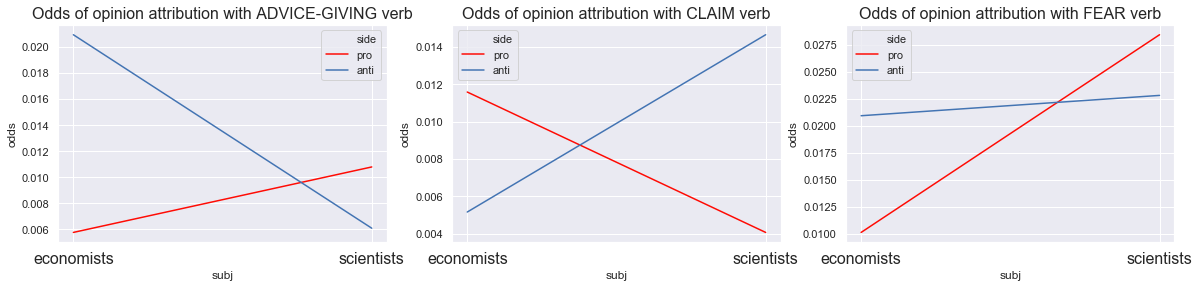

In [566]:
df = pd.DataFrame({'freq':[counts_dfs['cc']['sci'].loc[(counts_dfs['cc']['sci'].verb.isin(advice_verbs)) & 
                           (counts_dfs['cc']['sci'].side == 'pro')]['count'].values.sum(),
                          counts_dfs['cc']['sci'].loc[(counts_dfs['cc']['sci'].verb.isin(advice_verbs)) & 
                           (counts_dfs['cc']['sci'].side == 'anti')]['count'].values.sum(),
                          counts_dfs['cc']['econ'].loc[(counts_dfs['cc']['econ'].verb.isin(advice_verbs)) & 
                           (counts_dfs['cc']['econ'].side == 'pro')]['count'].values.sum(),
                          counts_dfs['cc']['econ'].loc[(counts_dfs['cc']['econ'].verb.isin(advice_verbs)) & 
                           (counts_dfs['cc']['econ'].side == 'anti')]['count'].values.sum()],
                  'side':['pro','anti']*2,
                  'subj':['sci']*2+['econ']*2})
df['odds'] = df['freq'].apply(freq2odds)
# df2 = pd.DataFrame({'freq':[counts_dfs['covid']['sci'].loc[(counts_dfs['covid']['sci'].verb.isin(advice_verbs)) & 
#                            (counts_dfs['covid']['sci'].side == 'pro')]['count'].values.sum(),
#                           counts_dfs['covid']['sci'].loc[(counts_dfs['covid']['sci'].verb.isin(advice_verbs)) & 
#                            (counts_dfs['covid']['sci'].side == 'anti')]['count'].values.sum(),
#                           counts_dfs['covid']['econ'].loc[(counts_dfs['covid']['econ'].verb.isin(advice_verbs)) & 
#                            (counts_dfs['covid']['econ'].side == 'pro')]['count'].values.sum(),
#                           counts_dfs['covid']['econ'].loc[(counts_dfs['covid']['econ'].verb.isin(advice_verbs)) & 
#                            (counts_dfs['covid']['econ'].side == 'anti')]['count'].values.sum()],
#                   'side':['pro','anti']*2,
#                   'subj':['sci']*2+['econ']*2})
df2 = pd.DataFrame({'freq':[counts_dfs['cc']['sci'].loc[(counts_dfs['cc']['sci'].verb.isin(claim_verbs)) & 
                           (counts_dfs['cc']['sci'].side == 'pro')]['count'].values.sum(),
                          counts_dfs['cc']['sci'].loc[(counts_dfs['cc']['sci'].verb.isin(claim_verbs)) & 
                           (counts_dfs['cc']['sci'].side == 'anti')]['count'].values.sum(),
                          counts_dfs['cc']['econ'].loc[(counts_dfs['cc']['econ'].verb.isin(claim_verbs)) & 
                           (counts_dfs['cc']['econ'].side == 'pro')]['count'].values.sum(),
                          counts_dfs['cc']['econ'].loc[(counts_dfs['cc']['econ'].verb.isin(claim_verbs)) & 
                           (counts_dfs['cc']['econ'].side == 'anti')]['count'].values.sum()],
                  'side':['pro','anti']*2,
                  'subj':['sci']*2+['econ']*2})
df3 = pd.DataFrame({'freq':[counts_dfs['cc']['sci'].loc[(counts_dfs['cc']['sci'].verb.isin(fear_verbs)) & 
                           (counts_dfs['cc']['sci'].side == 'pro')]['count'].values.sum(),
                          counts_dfs['cc']['sci'].loc[(counts_dfs['cc']['sci'].verb.isin(fear_verbs)) & 
                           (counts_dfs['cc']['sci'].side == 'anti')]['count'].values.sum(),
                          counts_dfs['cc']['econ'].loc[(counts_dfs['cc']['econ'].verb.isin(fear_verbs)) & 
                           (counts_dfs['cc']['econ'].side == 'pro')]['count'].values.sum(),
                          counts_dfs['cc']['econ'].loc[(counts_dfs['cc']['econ'].verb.isin(fear_verbs)) & 
                           (counts_dfs['cc']['econ'].side == 'anti')]['count'].values.sum()],
                  'side':['pro','anti']*2,
                  'subj':['sci']*2+['econ']*2})
df['odds'] = df['freq'].apply(freq2odds)
df3['odds'] = df3['freq'].apply(freq2odds)
df2['odds'] = df2['freq'].apply(freq2odds)
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,4))
sns.lineplot(x='subj',y='odds',data=df,
           hue='side',ax=ax1)
ax1.set_title('Odds of opinion attribution with ADVICE-GIVING verb',fontsize=16)
ax1.set_xticklabels(['economists','scientists'],fontsize=16)
sns.lineplot(x='subj',y='odds',data=df2,
           hue='side',ax=ax2)
ax2.set_title('Odds of opinion attribution with CLAIM verb',fontsize=16)
ax2.set_xticklabels(['economists','scientists'],fontsize=16)
sns.lineplot(x='subj',y='odds',data=df3,
           hue='side',ax=ax3)
ax3.set_title('Odds of opinion attribution with FEAR verb',fontsize=16)
ax3.set_xticklabels(['economists','scientists'],fontsize=16)

Text(0.5, 1.0, 'COVID')

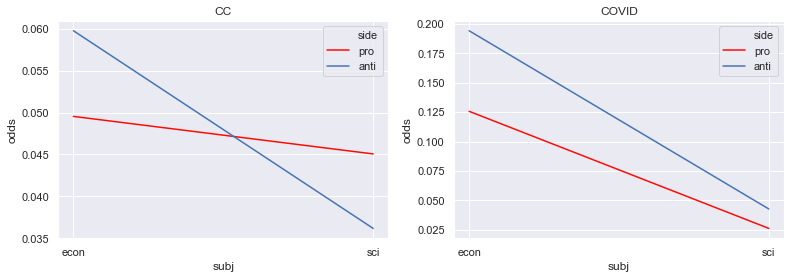

In [495]:
df = pd.DataFrame({'freq':[counts_dfs['cc']['sci'].loc[(counts_dfs['cc']['sci'].verb.isin(forward_verbs)) & 
                           (counts_dfs['cc']['sci'].side == 'pro')]['count'].values.sum(),
                          counts_dfs['cc']['sci'].loc[(counts_dfs['cc']['sci'].verb.isin(forward_verbs)) & 
                           (counts_dfs['cc']['sci'].side == 'anti')]['count'].values.sum(),
                          counts_dfs['cc']['econ'].loc[(counts_dfs['cc']['econ'].verb.isin(forward_verbs)) & 
                           (counts_dfs['cc']['econ'].side == 'pro')]['count'].values.sum(),
                          counts_dfs['cc']['econ'].loc[(counts_dfs['cc']['econ'].verb.isin(forward_verbs)) & 
                           (counts_dfs['cc']['econ'].side == 'anti')]['count'].values.sum()],
                  'side':['pro','anti']*2,
                  'subj':['sci']*2+['econ']*2})
df['odds'] = df['freq'].apply(freq2odds)
df2 = pd.DataFrame({'freq':[counts_dfs['covid']['sci'].loc[(counts_dfs['covid']['sci'].verb.isin(forward_verbs)) & 
                           (counts_dfs['covid']['sci'].side == 'pro')]['count'].values.sum(),
                          counts_dfs['covid']['sci'].loc[(counts_dfs['covid']['sci'].verb.isin(forward_verbs)) & 
                           (counts_dfs['covid']['sci'].side == 'anti')]['count'].values.sum(),
                          counts_dfs['covid']['econ'].loc[(counts_dfs['covid']['econ'].verb.isin(forward_verbs)) & 
                           (counts_dfs['covid']['econ'].side == 'pro')]['count'].values.sum(),
                          counts_dfs['covid']['econ'].loc[(counts_dfs['covid']['econ'].verb.isin(forward_verbs)) & 
                           (counts_dfs['covid']['econ'].side == 'anti')]['count'].values.sum()],
                  'side':['pro','anti']*2,
                  'subj':['sci']*2+['econ']*2})
df2['odds'] = df2['freq'].apply(freq2odds)
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(13,4))
sns.lineplot(x='subj',y='odds',data=df,
           hue='side',ax=ax1)
ax1.set_title('CC')
sns.lineplot(x='subj',y='odds',data=df2,
           hue='side',ax=ax2)
ax2.set_title('COVID')

Text(0.5, 1.0, 'COVID')

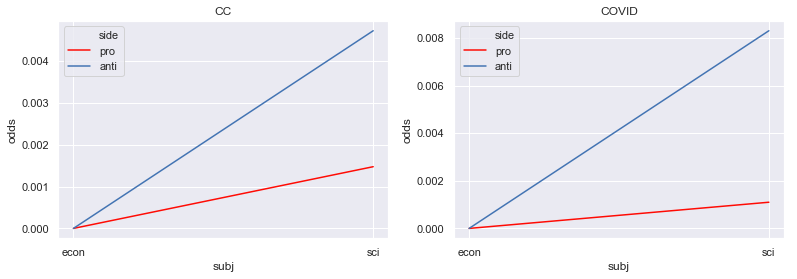

In [501]:
df = pd.DataFrame({'freq':[counts_dfs['cc']['sci'].loc[(counts_dfs['cc']['sci'].verb.isin(admit_verbs)) & 
                           (counts_dfs['cc']['sci'].side == 'pro')]['count'].values.sum(),
                          counts_dfs['cc']['sci'].loc[(counts_dfs['cc']['sci'].verb.isin(admit_verbs)) & 
                           (counts_dfs['cc']['sci'].side == 'anti')]['count'].values.sum(),
                          counts_dfs['cc']['econ'].loc[(counts_dfs['cc']['econ'].verb.isin(admit_verbs)) & 
                           (counts_dfs['cc']['econ'].side == 'pro')]['count'].values.sum(),
                          counts_dfs['cc']['econ'].loc[(counts_dfs['cc']['econ'].verb.isin(admit_verbs)) & 
                           (counts_dfs['cc']['econ'].side == 'anti')]['count'].values.sum()],
                  'side':['pro','anti']*2,
                  'subj':['sci']*2+['econ']*2})
df['odds'] = df['freq'].apply(freq2odds)
df2 = pd.DataFrame({'freq':[counts_dfs['covid']['sci'].loc[(counts_dfs['covid']['sci'].verb.isin(admit_verbs)) & 
                           (counts_dfs['covid']['sci'].side == 'pro')]['count'].values.sum(),
                          counts_dfs['covid']['sci'].loc[(counts_dfs['covid']['sci'].verb.isin(admit_verbs)) & 
                           (counts_dfs['covid']['sci'].side == 'anti')]['count'].values.sum(),
                          counts_dfs['covid']['econ'].loc[(counts_dfs['covid']['econ'].verb.isin(admit_verbs)) & 
                           (counts_dfs['covid']['econ'].side == 'pro')]['count'].values.sum(),
                          counts_dfs['covid']['econ'].loc[(counts_dfs['covid']['econ'].verb.isin(admit_verbs)) & 
                           (counts_dfs['covid']['econ'].side == 'anti')]['count'].values.sum()],
                  'side':['pro','anti']*2,
                  'subj':['sci']*2+['econ']*2})
df2['odds'] = df2['freq'].apply(freq2odds)
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(13,4))
sns.lineplot(x='subj',y='odds',data=df,
           hue='side',ax=ax1)
ax1.set_title('CC')
sns.lineplot(x='subj',y='odds',data=df2,
           hue='side',ax=ax2)
ax2.set_title('COVID')

Text(0.5, 1.0, 'COVID')

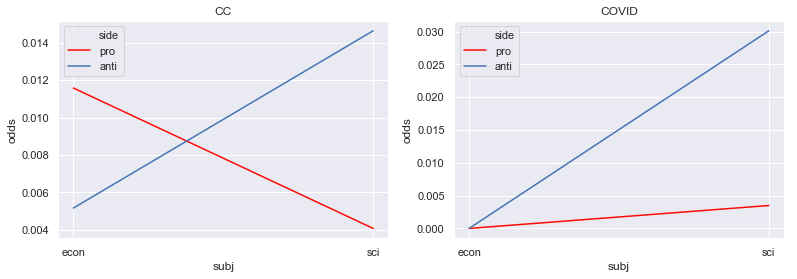

In [477]:
df = pd.DataFrame({'freq':[counts_dfs['cc']['sci'].loc[(counts_dfs['cc']['sci'].verb.isin(claim_verbs)) & 
                           (counts_dfs['cc']['sci'].side == 'pro')]['count'].values.sum(),
                          counts_dfs['cc']['sci'].loc[(counts_dfs['cc']['sci'].verb.isin(claim_verbs)) & 
                           (counts_dfs['cc']['sci'].side == 'anti')]['count'].values.sum(),
                          counts_dfs['cc']['econ'].loc[(counts_dfs['cc']['econ'].verb.isin(claim_verbs)) & 
                           (counts_dfs['cc']['econ'].side == 'pro')]['count'].values.sum(),
                          counts_dfs['cc']['econ'].loc[(counts_dfs['cc']['econ'].verb.isin(claim_verbs)) & 
                           (counts_dfs['cc']['econ'].side == 'anti')]['count'].values.sum()],
                  'side':['pro','anti']*2,
                  'subj':['sci']*2+['econ']*2})
df['odds'] = df['freq'].apply(freq2odds)
df2 = pd.DataFrame({'freq':[counts_dfs['covid']['sci'].loc[(counts_dfs['covid']['sci'].verb.isin(claim_verbs)) & 
                           (counts_dfs['covid']['sci'].side == 'pro')]['count'].values.sum(),
                          counts_dfs['covid']['sci'].loc[(counts_dfs['covid']['sci'].verb.isin(claim_verbs)) & 
                           (counts_dfs['covid']['sci'].side == 'anti')]['count'].values.sum(),
                          counts_dfs['covid']['econ'].loc[(counts_dfs['covid']['econ'].verb.isin(claim_verbs)) & 
                           (counts_dfs['covid']['econ'].side == 'pro')]['count'].values.sum(),
                          counts_dfs['covid']['econ'].loc[(counts_dfs['covid']['econ'].verb.isin(claim_verbs)) & 
                           (counts_dfs['covid']['econ'].side == 'anti')]['count'].values.sum()],
                  'side':['pro','anti']*2,
                  'subj':['sci']*2+['econ']*2})
df2['odds'] = df2['freq'].apply(freq2odds)
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(13,4))
sns.lineplot(x='subj',y='odds',data=df,
           hue='side',ax=ax1)
ax1.set_title('CC')
sns.lineplot(x='subj',y='odds',data=df2,
           hue='side',ax=ax2)
ax2.set_title('COVID')

Text(0.5, 1.0, 'COVID')

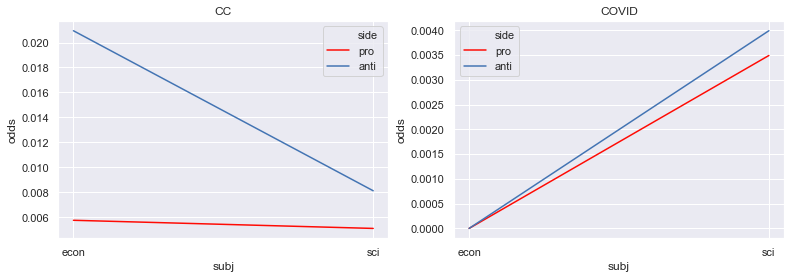

In [481]:
df = pd.DataFrame({'freq':[counts_dfs['cc']['sci'].loc[(counts_dfs['cc']['sci'].verb.isin(assert_verbs)) & 
                           (counts_dfs['cc']['sci'].side == 'pro')]['count'].values.sum(),
                          counts_dfs['cc']['sci'].loc[(counts_dfs['cc']['sci'].verb.isin(assert_verbs)) & 
                           (counts_dfs['cc']['sci'].side == 'anti')]['count'].values.sum(),
                          counts_dfs['cc']['econ'].loc[(counts_dfs['cc']['econ'].verb.isin(assert_verbs)) & 
                           (counts_dfs['cc']['econ'].side == 'pro')]['count'].values.sum(),
                          counts_dfs['cc']['econ'].loc[(counts_dfs['cc']['econ'].verb.isin(assert_verbs)) & 
                           (counts_dfs['cc']['econ'].side == 'anti')]['count'].values.sum()],
                  'side':['pro','anti']*2,
                  'subj':['sci']*2+['econ']*2})
df['odds'] = df['freq'].apply(freq2odds)
df2 = pd.DataFrame({'freq':[counts_dfs['covid']['sci'].loc[(counts_dfs['covid']['sci'].verb.isin(assert_verbs)) & 
                           (counts_dfs['covid']['sci'].side == 'pro')]['count'].values.sum(),
                          counts_dfs['covid']['sci'].loc[(counts_dfs['covid']['sci'].verb.isin(assert_verbs)) & 
                           (counts_dfs['covid']['sci'].side == 'anti')]['count'].values.sum(),
                          counts_dfs['covid']['econ'].loc[(counts_dfs['covid']['econ'].verb.isin(assert_verbs)) & 
                           (counts_dfs['covid']['econ'].side == 'pro')]['count'].values.sum(),
                          counts_dfs['covid']['econ'].loc[(counts_dfs['covid']['econ'].verb.isin(assert_verbs)) & 
                           (counts_dfs['covid']['econ'].side == 'anti')]['count'].values.sum()],
                  'side':['pro','anti']*2,
                  'subj':['sci']*2+['econ']*2})
df2['odds'] = df2['freq'].apply(freq2odds)
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(13,4))
sns.lineplot(x='subj',y='odds',data=df,
           hue='side',ax=ax1)
ax1.set_title('CC')
sns.lineplot(x='subj',y='odds',data=df2,
           hue='side',ax=ax2)
ax2.set_title('COVID')

Text(0.5, 1.0, 'COVID')

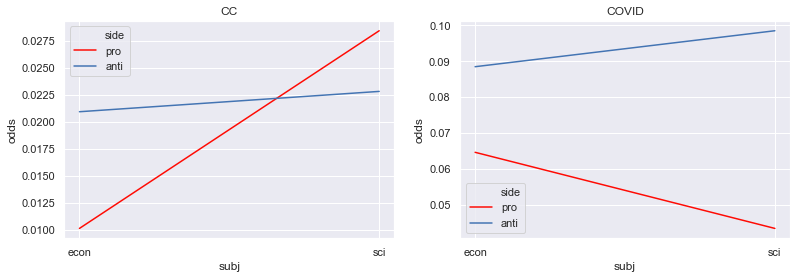

In [493]:
df = pd.DataFrame({'freq':[counts_dfs['cc']['sci'].loc[(counts_dfs['cc']['sci'].verb.isin(fear_verbs)) & 
                           (counts_dfs['cc']['sci'].side == 'pro')]['count'].values.sum(),
                          counts_dfs['cc']['sci'].loc[(counts_dfs['cc']['sci'].verb.isin(fear_verbs)) & 
                           (counts_dfs['cc']['sci'].side == 'anti')]['count'].values.sum(),
                          counts_dfs['cc']['econ'].loc[(counts_dfs['cc']['econ'].verb.isin(fear_verbs)) & 
                           (counts_dfs['cc']['econ'].side == 'pro')]['count'].values.sum(),
                          counts_dfs['cc']['econ'].loc[(counts_dfs['cc']['econ'].verb.isin(fear_verbs)) & 
                           (counts_dfs['cc']['econ'].side == 'anti')]['count'].values.sum()],
                  'side':['pro','anti']*2,
                  'subj':['sci']*2+['econ']*2})
df['odds'] = df['freq'].apply(freq2odds)
df2 = pd.DataFrame({'freq':[counts_dfs['covid']['sci'].loc[(counts_dfs['covid']['sci'].verb.isin(fear_verbs)) & 
                           (counts_dfs['covid']['sci'].side == 'pro')]['count'].values.sum(),
                          counts_dfs['covid']['sci'].loc[(counts_dfs['covid']['sci'].verb.isin(fear_verbs)) & 
                           (counts_dfs['covid']['sci'].side == 'anti')]['count'].values.sum(),
                          counts_dfs['covid']['econ'].loc[(counts_dfs['covid']['econ'].verb.isin(fear_verbs)) & 
                           (counts_dfs['covid']['econ'].side == 'pro')]['count'].values.sum(),
                          counts_dfs['covid']['econ'].loc[(counts_dfs['covid']['econ'].verb.isin(fear_verbs)) & 
                           (counts_dfs['covid']['econ'].side == 'anti')]['count'].values.sum()],
                  'side':['pro','anti']*2,
                  'subj':['sci']*2+['econ']*2})
df2['odds'] = df2['freq'].apply(freq2odds)
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(13,4))
sns.lineplot(x='subj',y='odds',data=df,
           hue='side',ax=ax1)
ax1.set_title('CC')
sns.lineplot(x='subj',y='odds',data=df2,
           hue='side',ax=ax2)
ax2.set_title('COVID')

In [612]:
topic_sci_verb_log_odds_ratios_pro_anti = {}
for topic in ['cc','covid']:
    topic_sci_verb_log_odds_ratios_pro_anti[topic] = do_log_odds(topic_side_sci_verb_toks[topic]['pro'],
                                                                 topic_side_sci_verb_toks[topic]['anti'])
    
topic_econ_verb_log_odds_ratios_pro_anti = {}
for topic in ['cc','covid']:
    topic_econ_verb_log_odds_ratios_pro_anti[topic] = do_log_odds(topic_side_econ_verb_toks[topic]['pro'],
                                                                 topic_side_econ_verb_toks[topic]['anti'])

In [614]:
ratio_df,verb_df,subj_df = [],[],[]
for v in topic_sci_verb_log_odds_ratios_pro_anti['cc']:
    if v in topic_econ_verb_log_odds_ratios_pro_anti['cc']:
        verb_df.extend([v]*2)
        subj_df.append('sci')
        ratio_df.append(topic_sci_verb_log_odds_ratios_pro_anti['cc'][v])
        subj_df.append('econ')
        ratio_df.append(topic_econ_verb_log_odds_ratios_pro_anti['cc'][v])

In [615]:
sci_econ_df = pd.DataFrame({'L_R_ratio':ratio_df,
             'verb':verb_df,
             'subj':subj_df})

In [599]:
#sci_econ_df = sci_econ_df.sort_values(by='subj')

In [616]:
import scipy.stats as stats
# covid
stats.spearmanr(sci_econ_df.loc[sci_econ_df.subj=='sci'].L_R_ratio.values,
               sci_econ_df.loc[sci_econ_df.subj=='econ'].L_R_ratio.values)

SpearmanrResult(correlation=0.1060226161889587, pvalue=0.2573284645118338)

In [608]:
# cc
stats.spearmanr(sci_econ_df.loc[sci_econ_df.subj=='sci'].L_R_ratio.values,
               sci_econ_df.loc[sci_econ_df.subj=='econ'].L_R_ratio.values)

SpearmanrResult(correlation=-0.10540925533894598, pvalue=0.894590744661054)

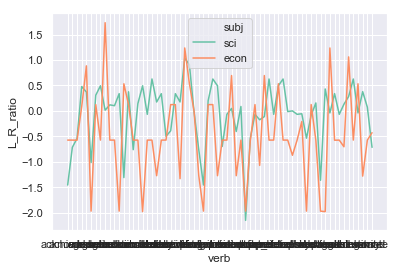

In [592]:
sns.lineplot(x='verb',y='L_R_ratio',data=sci_econ_df,hue='subj')

# Scientist quotes themselves

In [42]:
pd.set_option('max_colwidth', 400)

In [38]:
anti_sci_quotes = [q['quote text'] for q in anti_scientist_quotes]
pro_sci_quotes = [q['quote text'] for q in pro_scientist_quotes]

In [40]:
anti_sci_quote_strs = [' '.join(x) for x in anti_sci_quotes]
pro_sci_quote_strs = [' '.join(x) for x in anti_sci_quotes]

In [43]:
pd.DataFrame(anti_sci_quote_strs[:100])

0
0   the system is an indispensable tool for measuring local temperatures , and that its readings are buttressed by the consensus drawn from the 8,000 surface stations that make up the Cooperative Observer Program , the overall national system of which the 1,218 stations in the Historical Climatology Network are just a part
1                                                                                                                                                                                                                                                                                           whether the adjustments were appropriate
2                                                                                                                                                     Bremer Canyon , for example , is home to the Southern Hemisphere 's largest seasonal gathering of killer whales and often hosts traveling sharks , dolphins , squids and birds
3                                                                                                                                                                                                                                                                              which did its best to deny that the Pause was a thing
4                                                                                                                                                                                                                                                                                     it was wrong than actually looking at the data
..                                                                                                                                                                                                                                                                                                                               ...
95                                                                                                                                                                                                                                 it is currently warming , albeit very slowly , but that the warming is n’t being caused by humans
96                                                                                                                                                                                                                              They found that the age of the trash introduced an intriguing new timeline for the Byzantine decline
97                                                                                                                                 that trash disposal — once a well - organized and reliable service in outpost cities like Elusa — ceased around the middle of the sixth century , about 100 years prior to the empire 's collapse
98                                                                                                                                                                                                                             This suggested there was a failure of infrastructure , which happens when a city is about to collapse
99                                                                                                                                                                                                                  that Elusa 's decline began at least a century before Islamic rule wrested control of the region from the Romans

[100 rows x 1 columns]

# How each side describes different source entities

In [669]:
POS_ADJS = set(['novel','new','landmark','ground-breaking','prominent','expert','leading','foremost','eminent',
               'peer-reviewed','distinguished'])
NEG_ADJS = set(['debunked','flawed','skeptic','skeptical','dishonest','outspoken','preliminary'])

GENERIC_ADJS = set(['many','numerous','multiple'])

In [560]:
Counter(covid_neg_subj_adjs)

Counter({'skeptic': 61,
         'Skeptic': 2,
         'skeptical': 36,
         'Skeptical': 15,
         'debunked': 6,
         'flawed': 7,
         'Dishonest': 1})

## Scientists as sources

For this, we look at the broader lemmas that are part of the subtree of instances of "scientist", "researcher", etc.

In [561]:
def get_adjs_for_subj(subj_set,adj_set,topic_set=TOPICS,get_df=False):
    subj_quotes = defaultdict(dict)
    for topic in topic_set:
        for side in SIDES:
            subj_quotes[topic][side] = [q for q in quotes_by_topic_side[topic][side] if q['main subject lemma coref'] is not None and \
                            (q['main subject lemma coref'].lower() in subj_set or \
                           q['main subject text'].lower() in subj_set or \
                            (q['main subject lemma coref'].lower() in ent_fuzzy_map and \
                             ent_fuzzy_map[q['main subject lemma coref'].lower()] in subj_set))]
            
    topic_side_subj_adj_toks = defaultdict(dict)
    for topic in topic_set:
        for side in SIDES:
            adjs = [[a for a in q['subject text'] if a.lower() in adj_set]
                                                     for q in subj_quotes[topic][side]]
            topic_side_subj_adj_toks[topic][side] = [item.lower() for sublist in adjs for item in sublist]
            print(topic,side,len(topic_side_subj_adj_toks[topic][side]))
            
    topic_subj_adj_log_odds_ratios_pro_anti = {}
    for topic in topic_set:
        topic_subj_adj_log_odds_ratios_pro_anti[topic] = do_log_odds(topic_side_subj_adj_toks[topic]['pro'],
                                                                     topic_side_subj_adj_toks[topic]['anti'])
        
    topic_subj_adj_sorted_lor_pro_anti = {}
    for topic in topic_set:
         topic_subj_adj_sorted_lor_pro_anti[topic] = sorted(topic_subj_adj_log_odds_ratios_pro_anti[topic].items(),
                                                            key=lambda x:x[1],reverse=True)

    subj_adj_dfs = {}
    for topic in topic_set:
        adj_df,lor_df = [],[]
        for item in topic_subj_adj_sorted_lor_pro_anti[topic][:15]+\
        topic_subj_adj_sorted_lor_pro_anti[topic][-15:]:
            a = item[0]
            lor = item[1]
            adj_df.append(a)
            lor_df.append(lor)
        subj_adj_df = pd.DataFrame({"adj":adj_df,
                                   "log_odds_ratio":lor_df})
        subj_adj_dfs[topic] = subj_adj_df
        fig,ax=plt.subplots(figsize=(13,6))
        sns.barplot(x='adj',y='log_odds_ratio',data=subj_adj_df,ax=ax)
        ax.set_xticklabels(subj_adj_df.adj.values,rotation=70,fontsize=20)
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_title("LOR of describing '{}' in L vs. R-leaning {} media".format(', '.join(subj_set),topic.upper()),
                     fontsize=20)
        
    if get_df:
        return subj_adj_dfs

cc pro 56
cc anti 20
vax pro 12
vax anti 23
covid pro 9
covid anti 3


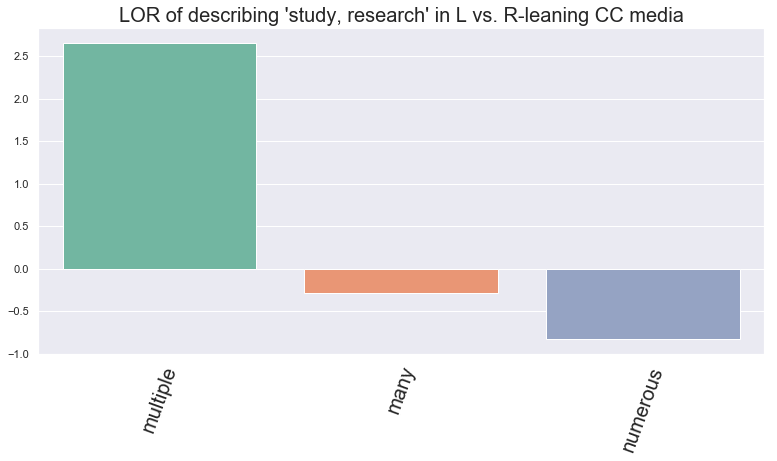

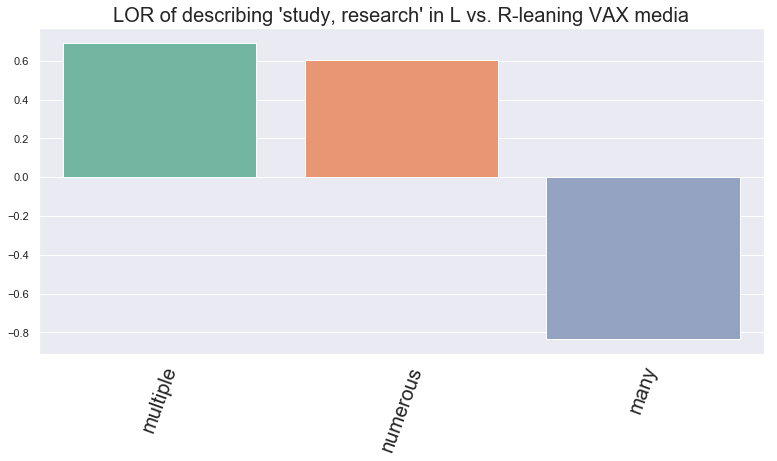

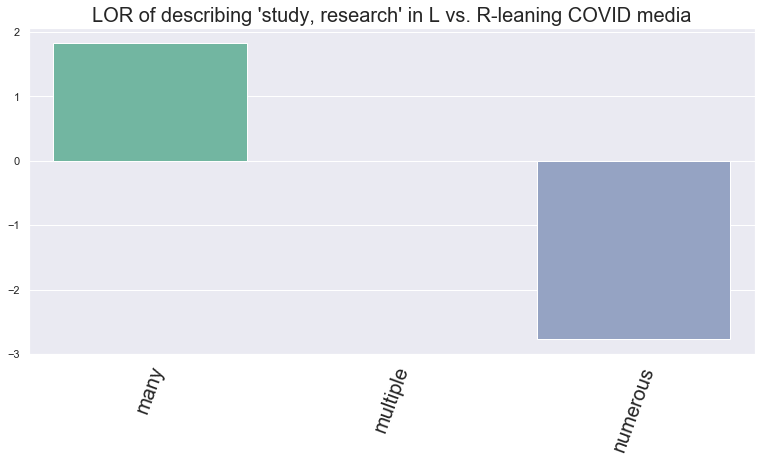

In [562]:
get_adjs_for_subj(['study','research'],GENERIC_ADJS,topic_set=TOPICS)

cc pro 532
cc anti 308
vax pro 49
vax anti 23
covid pro 82
covid anti 60


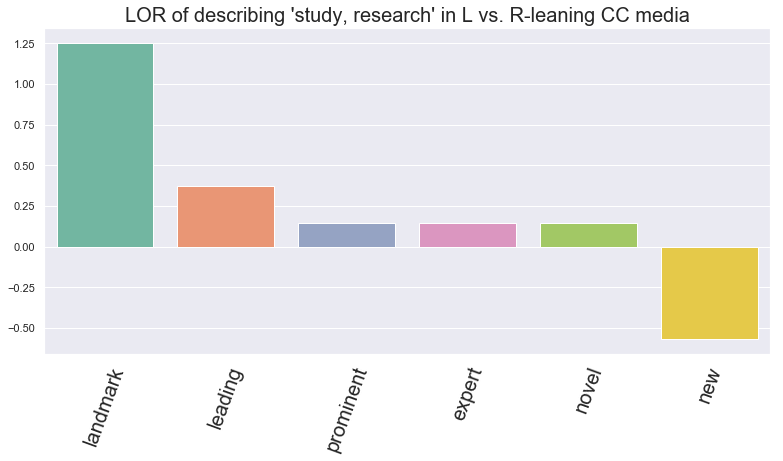

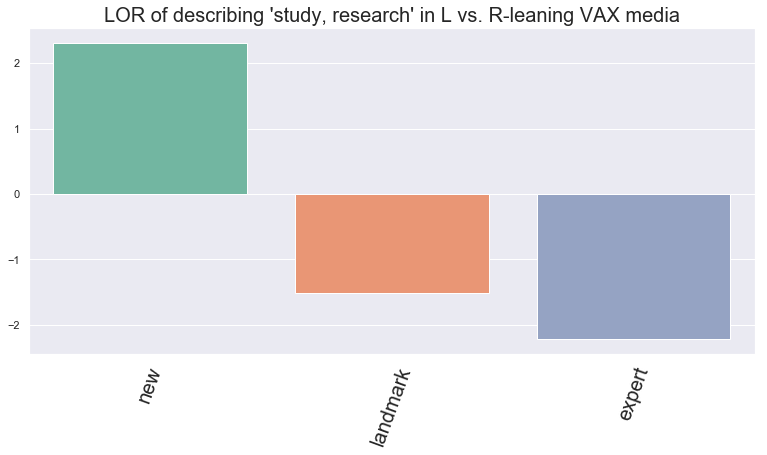

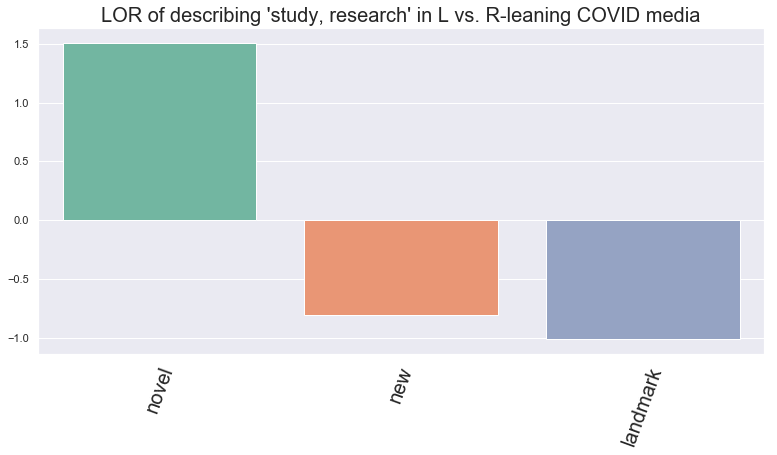

In [563]:
get_adjs_for_subj(['study','research'],POS_ADJS,topic_set=TOPICS)

In [680]:
get_adjs_for_subj(['study','research','data'],NEG_ADJS,topic_set=TOPICS)

cc pro 1
cc anti 0
vax pro 1
vax anti 0
covid pro 0
covid anti 0


ZeroDivisionError: float division by zero

In [67]:
contains_el(good_quotes[0]['subject lemmas'],SCIENTIST_SOURCES)

False

In [68]:
good_quotes[0]['subject lemmas']

['the', 'pro', '-', 'Trump', 'LaRouche', 'PAC', ',', 'which', 'believe', ',']

In [72]:
for topic in ['cc','vax']:
    for side in ['anti','pro']:
        qs_from_scientists = [q for q in good_quotes if q['topic'] == topic and q['stance'] == side and 
                             contains_el(q['subject lemmas'],SCIENTIST_SOURCES)]
        quotes_from_scientists_dict[topic][side] = qs_from_scientists

In [73]:
print(len(quotes_from_scientists_dict['cc']['pro']))
print(len(quotes_from_scientists_dict['cc']['anti']))

print(len(quotes_from_scientists_dict['vax']['pro']))
print(len(quotes_from_scientists_dict['vax']['anti']))

8447
4027
373
387


In [80]:
scientist_subject_lemmas_dict = defaultdict(dict)
for topic in TOPICS:
    for side in SIDES:
        subj_lemmas_scientists = [q['subject lemmas'] for q in quotes_from_scientists_dict[topic][side]]
        subj_lemmas_scientists = [item.lower() for sublist in subj_lemmas_scientists for item in sublist]
        scientist_subject_lemmas_dict[topic][side] = subj_lemmas_scientists

In [111]:
sorted(Counter(scientist_subject_lemmas_dict['cc']['pro']).items(),key=lambda x:x[1],reverse=True)

[('scientist', 5909),
 ('the', 3938),
 (',', 3459),
 ('researcher', 2576),
 ('a', 1957),
 ('of', 1808),
 ('at', 1467),
 ('and', 1282),
 ('climate', 1164),
 ('university', 901),
 ('who', 764),
 ('in', 717),
 ('study', 426),
 ('research', 390),
 ('-', 363),
 ('for', 357),
 ('’s', 352),
 ('some', 320),
 ('an', 301),
 ('lead', 281),
 ('with', 271),
 ('by', 260),
 ('be', 251),
 ('on', 242),
 ('author', 238),
 ('institute', 230),
 ('many', 227),
 ('senior', 224),
 ('national', 223),
 ('from', 222),
 ('atmospheric', 208),
 ('center', 197),
 ('nasa', 194),
 ('-pron-', 178),
 ('one', 170),
 ('environmental', 168),
 ('other', 159),
 ('to', 142),
 ('state', 141),
 ('change', 139),
 ('group', 136),
 ('report', 136),
 ('political', 133),
 ('california', 132),
 ('most', 130),
 ('new', 128),
 ('have', 121),
 ('work', 119),
 ('team', 110),
 ('"', 110),
 ('that', 108),
 ('science', 104),
 ('james', 101),
 ('michael', 99),
 ('dr.', 99),
 ('chief', 98),
 ('not', 97),
 ('international', 90),
 ('hansen', 8

In [112]:
sorted(Counter(scientist_subject_lemmas_dict['cc']['anti']).items(),key=lambda x:x[1],reverse=True)

[('scientist', 2574),
 ('the', 1835),
 ('researcher', 1478),
 (',', 1314),
 ('of', 767),
 ('a', 703),
 ('at', 546),
 ('and', 511),
 ('climate', 491),
 ('university', 395),
 ('in', 366),
 ('who', 285),
 ('-', 191),
 ('study', 190),
 ('research', 177),
 ('for', 147),
 ('with', 141),
 ("'s", 128),
 ('some', 127),
 ('lead', 118),
 ('nasa', 118),
 ('institute', 116),
 ('an', 110),
 ('national', 108),
 ('"', 106),
 ('on', 106),
 ('atmospheric', 105),
 ('author', 100),
 ('from', 98),
 ('be', 98),
 ('center', 96),
 ('many', 89),
 ('’s', 89),
 ('by', 85),
 ('-pron-', 79),
 ('senior', 75),
 ('one', 71),
 ('new', 69),
 ('earth', 63),
 ('group', 62),
 ('state', 61),
 ('to', 61),
 ('laboratory', 60),
 ('other', 59),
 ('most', 59),
 ('change', 58),
 ('team', 56),
 ('that', 56),
 ('environmental', 54),
 ('michael', 54),
 ('chief', 54),
 ('report', 54),
 ('science', 51),
 ('co', 50),
 ('dr.', 49),
 ('(', 49),
 (')', 48),
 ('global', 46),
 ('california', 45),
 ('have', 43),
 ('space', 43),
 ('percent',

In [83]:
log_odds_ratios_pro_anti_cc_sci_subj_lemmas = do_log_odds(scientist_subject_lemmas_dict['cc']['pro'],
                                                         scientist_subject_lemmas_dict['cc']['anti'])

In [84]:
sorted(log_odds_ratios_pro_anti_cc_sci_subj_lemmas.items(),key=lambda x:x[1],reverse=True)

[('both', 2.256274006239917),
 ('e.', 2.161257205207995),
 ('netherlands', 2.1096144693325356),
 ('advocate', 2.1096144693325356),
 ('a.', 1.9379641100023743),
 ('carolina', 1.9377081528332225),
 ('chairman', 1.8731509458697841),
 ('b.', 1.8731509458697841),
 ('pieter', 1.8731509458697841),
 ('health', 1.8045765853418452),
 ('social', 1.804357953817576),
 ('china', 1.804139388906119),
 ('d.', 1.804139388906119),
 ('j.', 1.7679716196299735),
 ('britain', 1.7302126019797082),
 ('economic', 1.7300127316248237),
 ('george', 1.6909731995083064),
 ('h.', 1.6499513391728415),
 ('methane', 1.6499513391728415),
 ('rob', 1.5629212777538803),
 ('post', 1.5629212777538803),
 ('williams', 1.5629212777538803),
 ('mr.', 1.5629212777538803),
 ('alan', 1.5629212777538803),
 ('working', 1.5629212777538803),
 ('lee', 1.5629212777538803),
 ('peters', 1.5165450585837559),
 ('glen', 1.4677362068424928),
 ('r.', 1.4677362068424928),
 ('north', 1.4677362068424928),
 ('overwhelming', 1.4677362068424928),
 ('pr

In [85]:
sorted(log_odds_ratios_pro_anti_cc_sci_subj_lemmas.items(),key=lambda x:x[1],reverse=False)

[('cato', -3.4011686419006932),
 ('knappenberger', -3.3205412708967676),
 ('chip', -3.3205412708967676),
 ('man', -2.9149038455521454),
 ('pat', -2.9149038455521454),
 ('may', -2.781329378257676),
 ('very', -2.627135625615818),
 ('cold', -2.627135625615818),
 ('army', -2.444770997862451),
 ('visit', -2.444770997862451),
 ('insist', -2.444770997862451),
 ('engineers', -2.444770997862451),
 ('michaels', -2.2827129984914873),
 ('greenbelt', -2.2217379840532954),
 ('libertarian', -2.2217379840532954),
 ('climatologist', -2.2215843774438566),
 ('marshall', -2.2215843774438566),
 ('famous', -2.2215843774438566),
 ('turner', -2.2215843774438566),
 ('adams', -2.2215843774438566),
 ('gaia', -2.2215843774438566),
 ('geophysics', -2.2215843774438566),
 ('nongovernmental', -2.2215843774438566),
 ('perovich', -2.2215843774438566),
 ('nancy', -2.2215843774438566),
 ('16', -2.2215843774438566),
 ('ohio', -2.1348371609193),
 ('palisades', -2.0881635167588257),
 ('csiro', -1.9339697641169677),
 ('danis

In [ ]:
# famous, skeptical, outspoken, distinguished

# How each side describes scientists (in quotes)

# When a scientist is described as an "expert", or the source entity is simply "expert", is the quote stance different?

# How often does media quote from scientists vs. studies?

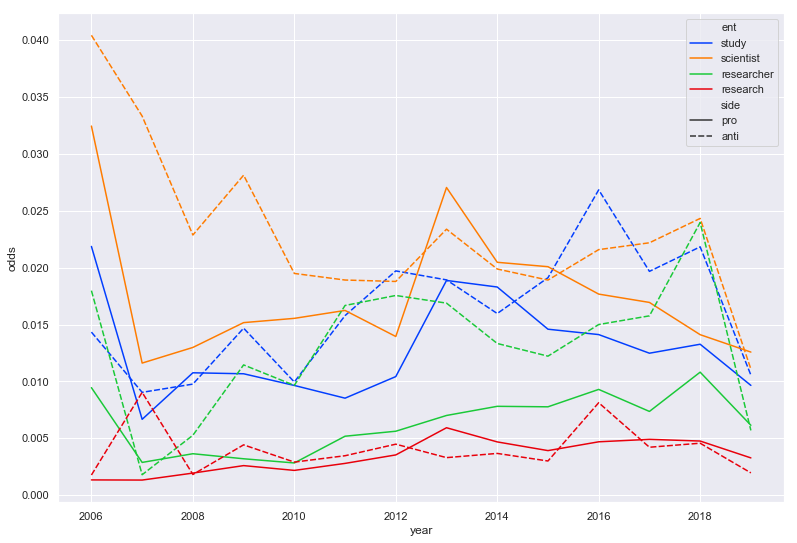

In [663]:
get_subj_df_over_time(['study','scientist','researcher','research'])

# Verbs of op. attr. for studies

cc pro 4563
cc anti 2203
vax pro 552
vax anti 625
covid pro 1104
covid anti 949


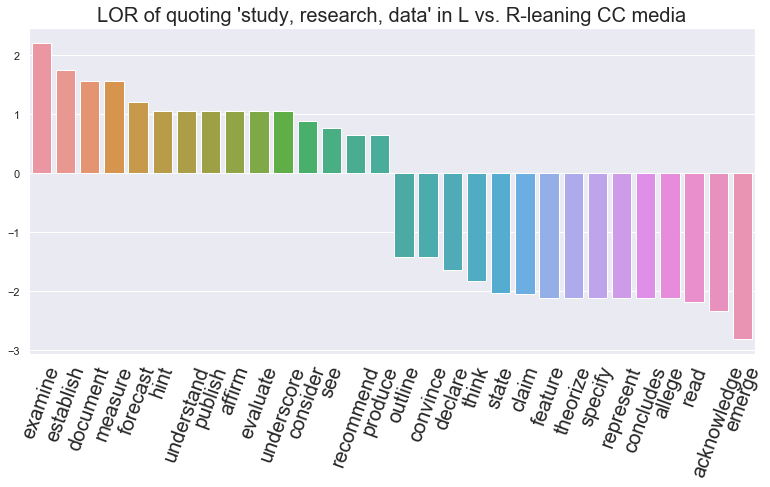

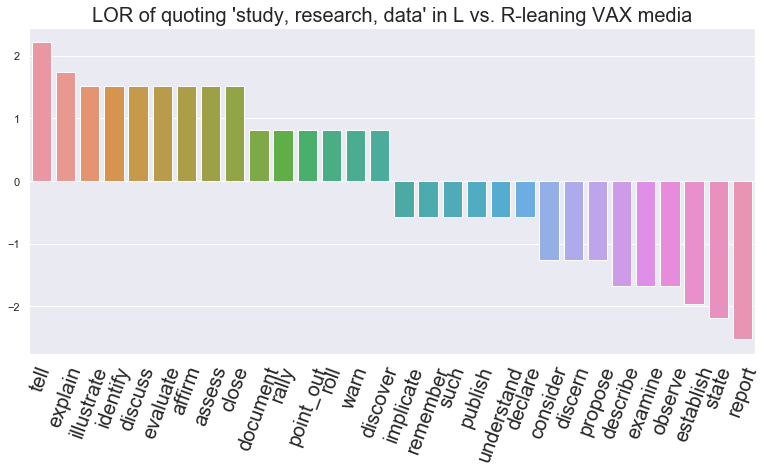

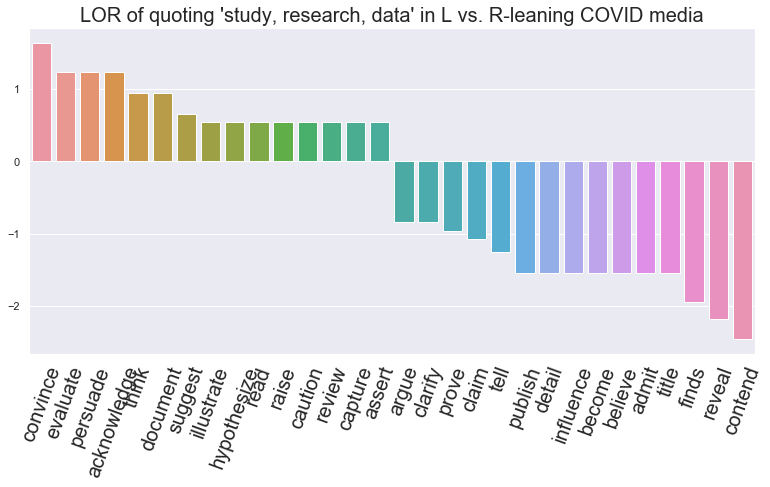

In [664]:
get_verbs_for_subj(['study','research','data'],topic_set=TOPICS,get_df=False)

In [ ]:
arg_verbs = ['argue','declare','contend']
claim_verbs = ['claim','allege']
admit_verbs = ['admit','acknowledge']
prove_verbs = ['prove']

# How studies are described

cc pro 546
cc anti 314


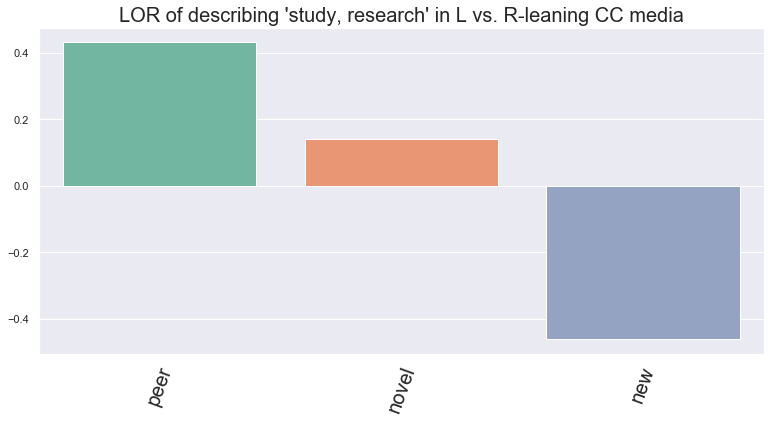

In [679]:
get_adjs_for_subj(['study','research'],['peer','novel','new'],topic_set=['cc'],get_df=False)

In [684]:
# study_subj_quotes = defaultdict(dict)
# for topic in ['cc','covid']:
#     for side in SIDES:
#         study_subj_quotes[topic][side] = [q for q in quotes_by_topic_side[topic][side] if q['main subject lemma coref'] is not None and \
#                         (q['main subject lemma coref'].lower() in ['study','research'] or \
#                        q['main subject text'].lower() in ['study','research'] or \
#                         (q['main subject lemma coref'].lower() in ent_fuzzy_map and \
#                          ent_fuzzy_map[q['main subject lemma coref'].lower()] in ['study','research']))]
#         print(topic,side,len(study_subj_quotes[topic][side]))

topic_side_study_subj_adj_toks = defaultdict(dict)
for topic in ['cc','covid']:
    for side in SIDES:
        adjs = [q['subject text'] for q in study_subj_quotes[topic][side]]
        topic_side_study_subj_adj_toks[topic][side] = [item.lower() for sublist in adjs for item in sublist]
        print(topic,side,len(topic_side_study_subj_adj_toks[topic][side]))

cc pro 20279
cc anti 9182
covid pro 4340
covid anti 3954


In [685]:
pr_study_quotes = defaultdict(dict)
for topic in ['cc','covid']:
    for side in SIDES:
        prs_ = [q for q in study_subj_quotes[topic][side] if 'peer' in q['subject text'] and 
               'reviewed' in q['subject text']]
        pr_study_quotes[topic][side] = prs_
        print(topic,side,len(prs_))

cc pro 32
cc anti 13
covid pro 7
covid anti 3


In [687]:
pr_study_quotes['cc']['anti']

[{'quote lemmas': ['the',
   'most',
   'important',
   'message',
   'of',
   'the',
   'calculation',
   'report',
   'here',
   'be',
   'that',
   'substitute',
   'natural',
   'gas',
   'for',
   'coal',
   'and',
   'oil',
   'be',
   'a',
   'significant',
   'way',
   'to',
   'reduce',
   'greenhouse',
   'force',
   ',',
   'regardless',
   'of',
   'how',
   'long',
   'the',
   'substitution',
   'take',
   ','],
  'quote lemmas coref': ['the',
   'most',
   'important',
   'message',
   'of',
   'the',
   'calculation',
   'report',
   'here',
   'be',
   'that',
   'substitute',
   'natural',
   'gas',
   'for',
   'coal',
   'and',
   'oil',
   'be',
   'a',
   'significant',
   'way',
   'to',
   'reduce',
   'greenhouse',
   'force',
   ',',
   'regardless',
   'of',
   'how',
   'long',
   'the',
   'substitution',
   'take',
   ','],
  'verb lemmas': ['say'],
  'verb lemmas coref': ['say'],
  'main verb lemma': 'say',
  'main verb lemma coref': 'say',
  'subject lem

In [688]:
pr_study_quotes['cc']['pro']

[{'quote lemmas': ['that',
   'the',
   'novel',
   'coronavirus',
   'have',
   'be',
   'spread',
   'most',
   'readily',
   'along',
   'an',
   'east',
   '-',
   'west',
   'band',
   'of',
   'the',
   'globe',
   'where',
   'the',
   'average',
   'temperature',
   'be',
   'between',
   '41',
   'and',
   '52',
   'degree',
   'and',
   'average',
   'humidity',
   'level'],
  'quote lemmas coref': ['that',
   'the novel coronavirus',
   'novel',
   'coronavirus',
   'have',
   'be',
   'spread',
   'most',
   'readily',
   'along',
   'an',
   'east',
   '-',
   'west',
   'band',
   'of',
   'the',
   'globe',
   'where',
   'the',
   'average',
   'temperature',
   'be',
   'between',
   '41',
   'and',
   '52',
   'degree',
   'and',
   'average',
   'humidity',
   'level'],
  'verb lemmas': ['show'],
  'verb lemmas coref': ['show'],
  'main verb lemma': 'show',
  'main verb lemma coref': 'show',
  'subject lemmas': ['a',
   'new',
   'study',
   ',',
   'which',
   'have

# Does each side simplify/essentialize the other side's arguments?

For example, does pro-cc news embed something along the lines of "climate change is a hoax" more than anti-cc news?

And does anti-cc news embed something along the lines of "the world is ending" more than pro-cc news?

# "We/you are told" type sentences

In [502]:
all_quotes[0].keys()

dict_keys(['quote lemmas', 'quote lemmas coref', 'verb lemmas', 'verb lemmas coref', 'main verb lemma', 'main verb lemma coref', 'subject lemmas', 'subject lemmas coref', 'main subject lemma', 'main subject lemma coref', 'neg lemmas', 'main neg lemma', 'quote text', 'verb text', 'main verb text', 'subject text', 'main subject text', 'is neg', 'source', 'stance', 'topic'])

In [504]:
we_quotes = defaultdict(dict)
for topic in TOPICS:
    for side in SIDES:
        we_quotes[topic][side] = [q for q in quotes_by_topic_side[topic][side] if 
                                  q['main subject text'] is not None and 
                        q['main subject text'].lower() == 'we']
        print(topic,side,len(we_quotes[topic][side]))

cc pro 10659
cc anti 4154
vax pro 1192
vax anti 304
covid pro 3457
covid anti 3881


In [515]:
we_told_quotes = defaultdict(dict)
for topic in TOPICS:
    for side in SIDES:
        we_told_quotes[topic][side] = [q for q in we_quotes[topic][side] if 
                                      'told' in q['verb text']]
        print(topic,side,len(we_told_quotes[topic][side]))

cc pro 119
cc anti 119
vax pro 24
vax anti 9
covid pro 47
covid anti 88


In [521]:
pd.set_option('display.max_colwidth', -1)
pd.DataFrame({"subj":[q['main subject text'] for q in we_told_quotes['cc']['anti']],
             "verb":[' '.join(q['verb text']) for q in we_told_quotes['cc']['anti']],
             "quote":[' '.join(q['quote text']) for q in we_told_quotes['cc']['anti']]}).iloc[
    [1,5,10,13,17,20,21,24,25,26,31,33,34,40,41,42,47,48,52,53,54,55,56,57,60,61,64,66,69,73,74,76,77,80,86,
    96,99,100,106,107]
]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


subj                                                       verb  \
1    We   been told                                                   
5    We   are told                                                    
10   we   Having ruled out substantial growth for brothers are told   
13   we   are told constantly                                         
17   We   've been told                                               
20   We   have also been told                                         
21   we   told                                                        
24   we   are told                                                    
25   we   For years have been told                                    
26   we   For at least a decade have been told                        
31   We   've all been told                                           
33   We   are told                                                    
34   We   are told                                                    
40   We   are told on nearly a daily basis                            
41   We   're told                                                    
42   We   're told                                                    
47   we   now 're told                                                
48   We   are being told                                              
52   we   For a long time were told                                   
53   we   are told the lie                                            
54   We   have also been told                                         
55   we   How many times have been told the lie                       
56   we   To scare the children repeatedly have been told             
57   We   been told repeatedly the bald                               
60   we   Back then were told                                         
61   we   now ’re being told                                          
64   we   are told constantly                                         
66   We   are all told                                                
69   We   have been told repeatedly                                   
73   we   were told                                                   
74   we   any remembers all through the 60s were told                 
76   We   are told                                                    
77   we   for some strange reason are relentlessly told               
80   we   were told                                                   
86   we   After billion years of the survival are told                
96   We   are told                                                    
99   We   are told                                                    
100  We   ’re often told                                              
106  we   when keep being told                                        
107  we   When point out inconsistencies 're told                     

                                                                                                                                                                                                  quote  
1    that the science is settled                                                                                                                                                                         
5    that unborn children have the right to clean air and that future generations deserve to be born into a planet free of climate catastrophe — but                                                     
10   that we will have to substantially redistribute the wealth of the West to the poor , so that the entire globe can live in a substantially lower ( for us ) but relatively equal standard of living  
13   that ‘ the science is settled ’                                                                                                                                                                     
17   it 's 100 percent peer - reviewed science                                    

In [524]:
pd.DataFrame({"subj":[q['main subject text'] for q in we_told_quotes['cc']['pro']],
             "verb":[' '.join(q['verb text']) for q in we_told_quotes['cc']['pro']],
             "quote":[' '.join(q['quote text']) for q in we_told_quotes['cc']['pro']]}).iloc[
    [1,2,79,87,88,101,116,6,27,29]
]

subj                     verb  \
1    we   were told                 
2    We   keep being told           
79   We   have been told            
87   we   At every step were told   
88   we   At every step were told   
101  We   have been told            
116  We   have been told            
6    We   ’re often told            
27   we   are told                  
29   We   are told                  

                                                                                                                                     quote  
1    there was global cooling                                                                                                               
2    that individual action wo n’t change anything , which is also an unfortunate message                                                   
79   that humanity is too greedy and selfish to rise to this challenge                                                                      
87   our goals were misguided or too ambitious                                                                                              
88   ; that we would crush jobs and explode deficits                                                                                        
101  that it is incompatible with our values , whereas in fact it ’s entirely compatible with conservative and with Christian values . ”    
116  that this is the “ new normal                                                                                                          
6    that there is a consensus among scientists                                                                                             
27   , that warmer ocean waters will make hurricanes more powerful                                                                          
29   climate change will cause more heatwaves and therefore more heat - related deaths

In [525]:
pd.DataFrame({"subj":[q['main subject text'] for q in we_told_quotes['vax']['anti']],
             "verb":[' '.join(q['verb text']) for q in we_told_quotes['vax']['anti']],
             "quote":[' '.join(q['quote text']) for q in we_told_quotes['vax']['anti']]})

subj  \
0  we    
1  we    
2  we    
3  we    
4  we    
5  we    
6  we    
7  We    
8  we    

                                                                          verb  \
0  that ’re told                                                                 
1  are told                                                                      
2  told                                                                          
3  when are told                                                                 
4  In contrast to inflammation of the kidneys are told                           
5  told                                                                          
6  for a long time were told now                                                 
7  told                                                                          
8  On the follow up visit a couple of weeks later on 60 Minutes were told Luke   

                                                                                                                                       quote  
0  is also required                                                                                                                           
1  The CDC ’s routine childhood vaccine schedule is based on solid science                                                                    
2  that the hepatitis B vaccine is a “ crucial shot ” for infants                                                                             
3  that HPV - induced cervical cancer “ often takes years , even decades , to develop after a person gets HPV                                 
4  that there is no reason for concern over brain inflammation                                                                                
5  vaccines are safe                                                                                                                          
6  a high - fat diet makes you fat it ’s …                                                                                                    
7  that in medical school a third or a half of what you learned this year will probably be wrong five years from now not just a little bit …  
8  had “

In [528]:
pd.DataFrame({"subj":[q['main subject text'] for q in we_told_quotes['covid']['anti']],
             "verb":[' '.join(q['verb text']) for q in we_told_quotes['covid']['anti']],
             "quote":[' '.join(q['quote text']) for q in we_told_quotes['covid']['anti']]}).iloc[
    [0,8,9,13,14,22,24,26,36,37,39]
]

subj                          verb  \
0   we   Still now told                 
8   we   were told not the virus        
9   we   when first started were told   
13  We   been told                      
14  we   were told                      
22  We   are being told                 
24  We   been told                      
26  we   initially were told            
36  we   for a long time were told      
37  we   In fact are now being told     
39  we   all of a sudden were told      

                                                                                                                                                                                             quote  
0   there are going to be millions of cases                                                                                                                                                         
8   Xenophobia and closed borders were the real threat                                                                                                                                              
9   this is just affecting older people –                                                                                                                                                           
13  that social distancing is the way to keep us safe                                                                                                                                               
14  Any amount of person - to - person contact increased the spread                                                                                                                                 
22  that life will not get back to “ normal ” until a vaccine arrives                                                                                                                               
24  this is a “ pandemic                                                                                                                                                                            
26  that the death toll in the United States would probably not be that high , but now that the death toll has already surpassed the number of Americans that died on 9/11 the message has changed  
36  that it was n’t to be taken seriously                                                                                                                                                           
37  that the death toll in the U.S. “ could reach 100,000 or more                                                                                                                                   
39  we have to wear masks all the time

In [529]:
pd.DataFrame({"subj":[q['main subject text'] for q in we_told_quotes['covid']['pro']],
             "verb":[' '.join(q['verb text']) for q in we_told_quotes['covid']['pro']],
             "quote":[' '.join(q['quote text']) for q in we_told_quotes['covid']['pro']]})

subj                                                                  verb  \
0   we   the next day told ’re unnecessary                                      
1   we   Instead now were being told                                            
2   We   been told                                                              
3   we   When already knew were still being told                                
4   We   been told                                                              
5   we   Initially were told                                                    
6   we   had just told them                                                     
7   we   are often told                                                         
8   we   Someday told him                                                       
9   we   told him                                                               
10  we   told him                                                               
11  We   reached out to the Department of Health seeking more masks were told   
12  We   initially were told                                                    
13  we   told too often                                                         
14  We   told                                                                   
15  We   told                                                                   
16  we   told you                                                               
17  We   told him                                                               
18  We   never discussed numbers told them                                      
19  We   were told                                                              
20  We   been told                                                              
21  we   yet also been told                                                     
22  we   Upon arrival at the Hospital in the middle of the night were told      
23  we   Even when been told                                                    
24  we   Even when been told                                                    
25  we   Even flatten told                                                      
26  we   So were told                                                           
27  We   been told                                                              
28  We   told them very clearly                                                 
29  we   So were told                                                           
30  We   were told                                                              
31  We   are being told                                                         
32  we   are also being told                                                    
33  we   After all are being told                                               
34  we   were told then with no evidence of human to human transmission         
35  we   Every week 're told                                                    
36  We   have told Congress                                                     
37  we   Weeks ago were told                                                    
38  we   In control are told                                                    
39  we   were told                                                              
40  we   Last night told you                                                    
41  We   ’re often told                                                         
42  we   In the early days of the epidemic were told                            
43  we   When already knew were still being told                                
44  We   are told                                                               
45  we   Instead have been told                                                 
46  we   are told                                                               

                                                                                                                  